In [1]:
import os
import copy
import cogdl
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cogdl import experiment
from cogdl.utils import set_random_seed
import gsim
import utils

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Load Dataset

In [2]:
from cogdl.datasets import build_dataset_from_path

data_path = "/home/stanislas/dataset/"
dataset_name = "chameleon"
dataset_mode = "inductive"
dataset = build_dataset_from_path(data_path=data_path, dataset=dataset_name)
train_nid = dataset.data.train_nid
val_nid = dataset.data.val_nid
test_nid = dataset.data.test_nid

checkpoint_dir = "./save_models/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
figure_dir = "./figures/{}".format("exp_0111_{}_64_2_avg".format(dataset_name))
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Build model

In [3]:
from custom_models.mlp import MLP
from custom_models.gcn import GCN
from custom_models.sgc import SGC
from custom_models.gin import GIN
from custom_models.appnp import APPNP

In [4]:
models_dict = {'mlp': {}, 'gcn': {}, 'sgc': {}, 'appnp': {}}
hidden_size = 64
num_layers = 2
order = 2
dropout = 0.5
residual = False
remove_self_loop = False
for seed in range(10):
    set_random_seed(seed)
    
    model_name = "mlp/{}/model_mlp_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, model_name)

    model = MLP(in_feats=dataset.num_features, 
                hidden_size=hidden_size,
                out_feats=dataset.num_classes,
                num_layers=num_layers,
                dropout=dropout)
    models_dict['mlp']['seed_{}'.format(seed)] = {'name': model_name,
                          'model': model,
                          'path': checkpoint_path}
    
    if residual:
        model_name = "model_gcn_res_{}_{}_seed_{}".format(hidden_size, num_layers, seed)
    else:
        model_name = "gcn/{}/model_gcn_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, "{}".format(model_name))

    model = GCN(in_feats=dataset.num_features, 
                hidden_size=hidden_size,
                out_feats=dataset.num_classes,
                num_layers=num_layers,
                residual=residual,
                dropout=dropout,
                remove_self_loop=remove_self_loop)
    models_dict['gcn']['seed_{}'.format(seed)]  = {'name': model_name,
                          'model': model,
                          'path': checkpoint_path}
    
    model_name = "sgc/{}/model_sgc_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, "{}".format(model_name))

    model = SGC(in_feats=dataset.num_features, 
                  hidden_size=hidden_size,
                  out_feats=dataset.num_classes,
                  num_layers=num_layers,
                  order=order,
                  dropout=dropout,
                  remove_self_loop=remove_self_loop)
    models_dict['sgc']['seed_{}'.format(seed)] = {'name': model_name,
                                                  'model': model,
                                                  'path': checkpoint_path}
    
    model_name = "appnp/{}/model_appnp_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, "{}".format(model_name))

    model = APPNP(nfeat=dataset.num_features, 
                  nhid=hidden_size,
                  nclass=dataset.num_classes,
                  num_layers=num_layers,
                dropout=dropout,
                alpha=0.1, 
                 niter=2)
    models_dict['appnp']['seed_{}'.format(seed)] = {'name': model_name,
                                                  'model': model,
                                                  'path': checkpoint_path}
    
#     model_name = "model_gin_{}_{}_k_{}_seed_{}".format(hidden_size, num_layers, order, seed)
#     checkpoint_path = os.path.join(checkpoint_dir, "{}.pt".format(model_name))

#     model = GIN(in_feats=dataset.num_features, 
#                   hidden_dim=hidden_size,
#                   out_feats=dataset.num_classes,
#                   num_layers=num_layers,
#                   num_mlp_layers=2,
#                   dropout=dropout)
#     models_dict['gin']['seed_{}'.format(seed)] = {'name': model_name,
#                                                   'model': model,
#                                                   'path': checkpoint_path}
    
#     for k in models_dict.keys():
#         experiment(model=models_dict[k]['seed_{}'.format(seed)]['model'], dataset=dataset, 
#                    checkpoint_path=models_dict[k]['seed_{}'.format(seed)]['path'], seed=[seed])

## Evaluation

In [5]:
def get_dist(pred1, pred2):
    # sim = torch.sum(torch.abs(pred1 - pred2)).item()
    # sim = gsim.cka(pred1, pred2, mode='rbf', threshold=0.8)
    sim = gsim.cka(pred1, pred2, mode='linear')
    # sim = torch.linalg.norm(pred1 - pred2, ord=1).item()
    
    return sim

In [6]:
from cogdl.wrappers.model_wrapper.node_classification import NodeClfModelWrapper
from cogdl.utils import spmm

In [7]:
for k in models_dict.keys():
    for seed in range(10):
        model_wrapper = NodeClfModelWrapper(models_dict[k]['seed_{}'.format(seed)]['model'], None)
        model_wrapper.load_state_dict(torch.load(models_dict[k]['seed_{}'.format(seed)]['path']))
        model = model_wrapper.model
        model.eval()
        models_dict[k]['seed_{}'.format(seed)]['model'] = model

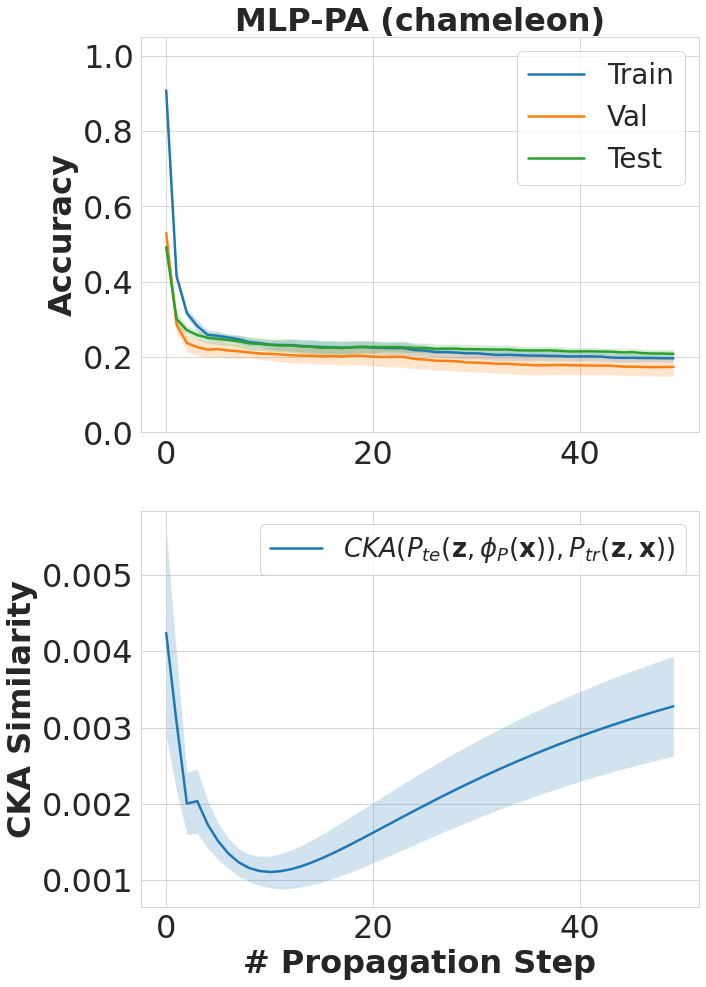

In [23]:
n_post = 50
n_dist_sample = len(dataset.data.test_nid)
for k in models_dict.keys():
    model_name = k.upper()
    if 'mlp' not in k.lower():
        continue
    post_props = np.arange(n_post)
    train_accs_10, val_accs_10, test_accs_10 = [], [], []
    train_conf_means_10, train_conf_stds_10 = [], []
    val_conf_means_10, val_conf_stds_10 = [], []
    test_conf_means_10, test_conf_stds_10 = [], []
    dist_all_10, dist_train_10, dist_test_10, dist_train_test_10, dist_train_orig_test_10 = [], [], [], [], []
    for seed in range(10):
        model = models_dict[k]['seed_{}'.format(seed)]['model']
        x_post = copy.deepcopy(dataset.data.x)
        graph = copy.deepcopy(dataset.data)
        if remove_self_loop:
            graph.remove_self_loops()
        else:
            graph.add_remaining_self_loops()
        graph.sym_norm()
        train_accs, val_accs, test_accs = [], [], []
        train_conf_means, train_conf_stds = [], []
        val_conf_means, val_conf_stds = [], []
        test_conf_means, test_conf_stds = [], []
        train_entropy_means, train_entropy_stds = [], []
        val_entropy_means, val_entropy_stds = [], []
        test_entropy_means, test_entropy_stds = [], []
        dist_all, dist_train, dist_test, dist_train_test, dist_train_orig_test = [], [], [], [], []
        pred_orig = None
        for n_post_prop in post_props:
            if 'mlp' in k.lower():
                pred = model.forward(x_post)
            else:
                graph = copy.deepcopy(dataset.data)
                if remove_self_loop:
                    graph.remove_self_loops()
                else:
                    graph.add_remaining_self_loops()
                graph.x = x_post
                graph.sym_norm()
                pred = model.embed_without_prop(graph, 2)
            if pred_orig is None:
                pred_orig = pred
            
            # Get Dist
#             dist_all.append(get_dist(pred, pred_orig))
#             dist_train.append(get_dist(dataset.data.x[dataset.data.train_nid], x_post[dataset.data.train_nid]))
#             dist_test.append(get_dist(pred[dataset.data.test_nid], pred_orig[dataset.data.test_nid]))
            dist_train_orig_test.append(get_dist(pred_orig[dataset.data.train_nid][:n_dist_sample], pred[dataset.data.test_nid][:n_dist_sample]))
            dist_train_test.append(get_dist(pred[dataset.data.train_nid][:n_dist_sample], pred[dataset.data.test_nid][:n_dist_sample]))
            # Get accuracy
            train_acc, val_acc, test_acc = utils.eval_acc(pred, dataset, verbose=False)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            # Get confidence
            train_confidence, val_confidence, test_confidence = utils.eval_confidence(pred, dataset, verbose=False)
            train_conf_means.append(torch.mean(train_confidence).item())
            val_conf_means.append(torch.mean(val_confidence).item())
            test_conf_means.append(torch.mean(test_confidence).item())
            train_conf_stds.append(torch.std(train_confidence).item())
            val_conf_stds.append(torch.std(val_confidence).item())
            test_conf_stds.append(torch.std(test_confidence).item())
            # Get entropy
            train_entropy, val_entropy, test_entropy = utils.eval_entropy(pred, dataset, verbose=False)
            train_entropy_means.append(torch.mean(train_entropy).item())
            val_entropy_means.append(torch.mean(val_entropy).item())
            test_entropy_means.append(torch.mean(test_entropy).item())
            train_entropy_stds.append(torch.std(train_entropy).item())
            val_entropy_stds.append(torch.std(val_entropy).item())
            test_entropy_stds.append(torch.std(test_entropy).item())
            x_post = spmm(graph, x_post)
#         dist_all_10.append(dist_all)
#         dist_train_10.append(dist_train)
#         dist_test_10.append(dist_test)
        dist_train_test_10.append(dist_train_test)
        dist_train_orig_test_10.append(dist_train_orig_test)
        train_accs_10.append(train_accs)
        val_accs_10.append(val_accs)
        test_accs_10.append(test_accs)
        train_conf_means_10.append(train_conf_means)
        train_conf_stds_10.append(train_conf_stds)
        val_conf_means_10.append(val_conf_means)
        val_conf_stds_10.append(val_conf_stds)
        test_conf_means_10.append(test_conf_means)
        test_conf_stds_10.append(test_conf_stds)
    
    train_acc_mean, train_acc_std = torch.tensor(train_accs_10).mean(dim=0).numpy(), torch.tensor(train_accs_10).std(dim=0).numpy()
    val_acc_mean, val_acc_std = torch.tensor(val_accs_10).mean(dim=0).numpy(), torch.tensor(val_accs_10).std(dim=0).numpy()
    test_acc_mean, test_acc_std = torch.tensor(test_accs_10).mean(dim=0).numpy(), torch.tensor(test_accs_10).std(dim=0).numpy()
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 16))
    axs[0].plot(post_props, train_acc_mean, linewidth=2.5, label="Train")
    axs[0].fill_between(post_props, train_acc_mean - train_acc_std, 
                        train_acc_mean + train_acc_std, alpha=0.2)
    axs[0].plot(post_props, val_acc_mean, linewidth=2.5, label="Val")
    axs[0].fill_between(post_props, val_acc_mean - val_acc_std, 
                        val_acc_mean + val_acc_std, alpha=0.2)
    axs[0].plot(post_props, test_acc_mean, linewidth=2.5, label="Test")
    axs[0].fill_between(post_props, test_acc_mean - test_acc_std, 
                        test_acc_mean + test_acc_std, alpha=0.2)
    axs[0].set_title("{}-PA ({})".format(model_name, dataset_name), fontsize=32, fontweight='bold')
    axs[0].set_ylim(0, 1.05)
    axs[0].set_ylabel("Accuracy", fontsize=32, fontweight='bold')
    # axs[0].set_xlabel("# Propagation Step", fontsize=32, fontweight='bold')
    axs[0].tick_params(axis="x", labelsize=32)
    axs[0].tick_params(axis="y", labelsize=32)
    axs[0].legend(fontsize=28, loc=1)
    
    # dist
#     dist_all_mean, dist_all_std = torch.tensor(dist_all_10).mean(dim=0).numpy(), torch.tensor(dist_all_10).std(dim=0).numpy()
#     dist_train_mean, dist_train_std = torch.tensor(dist_train_10).mean(dim=0).numpy(), torch.tensor(dist_train_10).std(dim=0).numpy()
#     dist_test_mean, dist_test_std = torch.tensor(dist_test_10).mean(dim=0).numpy(), torch.tensor(dist_test_10).std(dim=0).numpy()
    dist_train_test_mean, dist_train_test_std = torch.tensor(dist_train_test_10).mean(dim=0).numpy(), torch.tensor(dist_train_test_10).std(dim=0).numpy()
    dist_train_orig_test_mean, dist_train_orig_test_std = torch.tensor(dist_train_orig_test_10).mean(dim=0).numpy(), torch.tensor(dist_train_orig_test_10).std(dim=0).numpy()
    
#     axs[1].plot(post_props, dist_train_test_mean, label="Train vs. Test")
#     axs[1].fill_between(post_props, dist_train_test_mean - dist_train_test_std, 
#                         dist_train_test_mean + dist_train_test_std, alpha=0.2)
    axs[1].plot(post_props, dist_train_orig_test_mean, linewidth=2.5, label=r'$CKA(P_{te}(\mathbf{z}, \phi_P(\mathbf{x})), P_{tr}(\mathbf{z}, \mathbf{x}))$')
    axs[1].fill_between(post_props, dist_train_orig_test_mean - dist_train_orig_test_std, 
                        dist_train_orig_test_mean + dist_train_orig_test_std, alpha=0.2)
#     axs[1].plot(post_props, dist_train_mean, label="Train (orig) vs. Train")
#     axs[1].plot(post_props, dist_test_mean, label="Test (orig) vs. Test")
    # axs[1].set_title("{}-PA CKA ({})".format(model_name, dataset_name), fontsize=32, fontweight='bold')
    axs[1].set_ylabel("CKA Similarity", fontsize=32, fontweight='bold')
    axs[1].set_xlabel("# Propagation Step", fontsize=32, fontweight='bold')
    axs[1].tick_params(axis="x", labelsize=32)
    axs[1].tick_params(axis="y", labelsize=32)
    axs[1].legend(loc=1, fontsize=26)

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

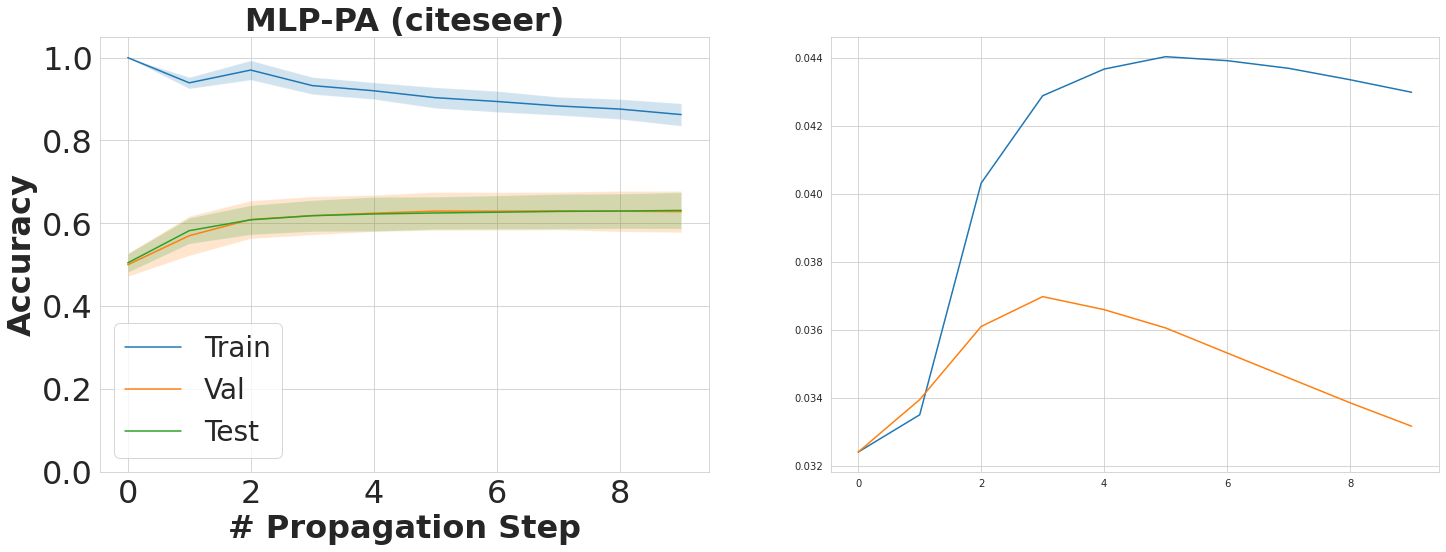

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0].plot(post_props, train_acc_mean, label="Train")
axs[0].fill_between(post_props, train_acc_mean - train_acc_std, 
                    train_acc_mean + train_acc_std, alpha=0.2)
axs[0].plot(post_props, val_acc_mean, label="Val")
axs[0].fill_between(post_props, val_acc_mean - val_acc_std, 
                    val_acc_mean + val_acc_std, alpha=0.2)
axs[0].plot(post_props, test_acc_mean, label="Test")
axs[0].fill_between(post_props, test_acc_mean - test_acc_std, 
                    test_acc_mean + test_acc_std, alpha=0.2)
axs[0].set_title("{}-PA ({})".format(model_name, dataset_name), fontsize=32, fontweight='bold')
axs[0].set_ylim(0, 1.05)
axs[0].set_ylabel("Accuracy", fontsize=32, fontweight='bold')
axs[0].set_xlabel("# Propagation Step", fontsize=32, fontweight='bold')
axs[0].tick_params(axis="x", labelsize=32)
axs[0].tick_params(axis="y", labelsize=32)
axs[0].legend(fontsize=28, loc=3)

# dist
dist_all_mean, dist_all_std = torch.tensor(dist_all_10).mean(dim=0).numpy(), torch.tensor(dist_all_10).std(dim=0).numpy()
dist_train_mean, dist_train_std = torch.tensor(dist_train_10).mean(dim=0).numpy(), torch.tensor(dist_train_10).std(dim=0).numpy()
dist_test_mean, dist_test_std = torch.tensor(dist_test_10).mean(dim=0).numpy(), torch.tensor(dist_test_10).std(dim=0).numpy()
dist_train_test_mean, dist_train_test_std = torch.tensor(dist_train_test_10).mean(dim=0).numpy(), torch.tensor(dist_train_test_10).std(dim=0).numpy()
dist_train_orig_test_mean, dist_train_orig_test_std = torch.tensor(dist_train_orig_test_10).mean(dim=0).numpy(), torch.tensor(dist_train_orig_test_10).std(dim=0).numpy()

axs[1].plot(post_props, dist_train_test_mean, label="Train vs. Test")
# axs[1].fill_between(post_props, dist_train_test_mean - dist_train_test_std, 
#                     dist_train_test_mean + dist_train_test_std, alpha=0.2)
axs[1].plot(post_props, dist_train_orig_test_mean, label="Train (orig) vs. Test")
axs[1].plot(post_props, dist_train_mean, label="Train (orig) vs. Train")
axs[1].plot(post_props, dist_test_mean, label="Test (orig) vs. Test")

axs[1].set_title("{}-PA CKA ({})".format(model_name, dataset_name), fontsize=32, fontweight='bold')
axs[1].set_ylabel("CKA Similarity", fontsize=32, fontweight='bold')
axs[1].set_xlabel("# Propagation Step", fontsize=32, fontweight='bold')
axs[1].tick_params(axis="x", labelsize=32)
axs[1].tick_params(axis="y", labelsize=32)
axs[1].legend(loc=4, fontsize=32)

In [34]:
import numpy as np
import os
import random
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from cogdl import experiment
from cogdl.datasets.planetoid_data import CoraDataset
from custom_models.mlp import MLP
from custom_models.gcn import GCN
from custom_models.sgc import SGC
from custom_models.appnp import APPNP

dataset = CoraDataset()
graph = dataset.data

mlp = MLP(
    in_feats = dataset.num_features,
    out_feats = dataset.num_classes,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.5,
    activation = "relu",
)

gcn = GCN(
    in_feats = dataset.num_features,
    out_feats = dataset.num_classes,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.5,
    activation = "relu",
    residual = False,
    remove_self_loop = False,
    norm = None,
)

sgc = SGC(
    in_feats = dataset.num_features,
    out_feats = dataset.num_classes,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.5,
    activation = "relu",
    norm = None,
    order = 2,
    remove_self_loop = False,
    bias = True,
)

appnp = APPNP(nfeat=dataset.num_features, 
              nhid=64,
              nclass=dataset.num_classes,
              num_layers=2,
              dropout=0.5,
              alpha=0.1, 
              niter=2)

#   Model Test
#
#   | Variant       | test_acc      | val_acc       |
#   |---------------|---------------|---------------|
#   | (Cora, 'MLP') | 0.5500±0.0092 | 0.5920±0.0116 |
#   | (Cora, 'GCN') | 0.8086±0.0071 | 0.7932±0.0020 |
#   | (Cora, 'SGC') | 0.8040±0.0066 | 0.7968±0.0026 |

# experiment(model=[mlp, gcn, sgc], dataset=dataset, seed=list(range(10)), epoch=500, devices=[0])

# Train: 0%, 10%, 20% -> 70%, Valid: 20%, Test: total - train -valid 

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model_class = {
    'mlp': mlp,
#     'gcn': gcn,
#     'sgc': sgc,
#     'appnp': appnp,
}

results = []

for i in range(1, 8):
    train_start = int(dataset.num_nodes * 0 / 10.0)
    train_end = int(dataset.num_nodes * i / 10.0)
    
    val_start = int(dataset.num_nodes * i / 10.0)
    val_end = int(dataset.num_nodes * (i+2) / 10.0)
    
    test_start = int(dataset.num_nodes * (i+2) / 10.0)
    test_end = int(dataset.num_nodes)
    
    perm = torch.randperm(dataset.num_nodes)

    graph.train_mask[:] = False
    graph.train_mask[perm[train_start:train_end]] = True

    graph.val_mask[:] = False
    graph.val_mask[perm[val_start:val_end]] = True

    graph.test_mask[:] = False
    graph.test_mask[perm[test_start:test_end]] = True

    # print ((graph.train_mask | graph.val_mask | graph.test_mask).sum().item(), graph.train_mask.sum().item() + graph.val_mask.sum().item() + graph.test_mask.sum().item())
    for model_name, model in model_class.items():
        ret = experiment(model=model, dataset=dataset, seed=list(range(10)), epoch=500, devices=[0])
        ret = list(ret.values())[0]
        test_acc = [items['test_acc'] for items in ret]
        test_acc = sum(test_acc) / len(test_acc)
        
        items = {
            'train_percent': i,
            'model_name': model_name,
            'test_acc': round(test_acc * 100, 2)
        }
        results.append(items)

for result in results:
    print (result)


Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 195, train_loss:  0.0129, val_acc:  0.5959:  39%|███▉      | 195/500 [00:00<00:00, 309.33it/s]


Saving 96-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5690928270042194, 'val_acc': 0.6014760147601476}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 297, train_loss:  0.0139, val_acc:  0.5923:  59%|█████▉    | 297/500 [00:00<00:00, 330.55it/s]


Saving 198-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.570675105485232, 'val_acc': 0.6014760147601476}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 309, train_loss:  0.0125, val_acc:  0.5941:  62%|██████▏   | 309/500 [00:01<00:00, 303.61it/s]


Saving 210-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5738396624472574, 'val_acc': 0.5977859778597786}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 205, train_loss:  0.0186, val_acc:  0.5886:  41%|████      | 205/500 [00:00<00:00, 343.01it/s]


Saving 106-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5759493670886076, 'val_acc': 0.5959409594095941}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 209, train_loss:  0.0144, val_acc:  0.5849:  42%|████▏     | 209/500 [00:00<00:00, 318.80it/s]


Saving 110-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.570675105485232, 'val_acc': 0.5904059040590406}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 156, train_loss:  0.0204, val_acc:  0.5812:  31%|███       | 156/500 [00:00<00:00, 345.12it/s]


Saving 57-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5638185654008439, 'val_acc': 0.5940959409594095}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 159, train_loss:  0.0403, val_acc:  0.5904:  32%|███▏      | 159/500 [00:00<00:01, 339.57it/s]


Saving 60-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5675105485232067, 'val_acc': 0.6014760147601476}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 195, train_loss:  0.0136, val_acc:  0.5812:  39%|███▉      | 195/500 [00:00<00:00, 314.90it/s]


Saving 96-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5664556962025317, 'val_acc': 0.5940959409594095}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 237, train_loss:  0.0113, val_acc:  0.5904:  47%|████▋     | 237/500 [00:00<00:00, 317.61it/s]


Saving 138-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.57542194092827, 'val_acc': 0.5959409594095941}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 254, train_loss:  0.0079, val_acc:  0.5793:  51%|█████     | 254/500 [00:00<00:00, 331.37it/s]


Saving 155-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5638185654008439, 'val_acc': 0.5959409594095941}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5697±0.0042 | 0.5969±0.0035 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------

Epoch: 279, train_loss:  0.0051, val_acc:  0.8506:  56%|█████▌    | 279/500 [00:00<00:00, 326.59it/s]


Saving 180-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8217299578059072, 'val_acc': 0.8579335793357934}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 378, train_loss:  0.0027, val_acc:  0.8469:  76%|███████▌  | 378/500 [00:01<00:00, 330.15it/s]


Saving 279-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8233122362869199, 'val_acc': 0.8560885608856088}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 330, train_loss:  0.0028, val_acc:  0.8506:  66%|██████▌   | 330/500 [00:01<00:00, 306.41it/s]


Saving 231-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8233122362869199, 'val_acc': 0.8579335793357934}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 226, train_loss:  0.0082, val_acc:  0.8487:  45%|████▌     | 226/500 [00:00<00:00, 281.32it/s]


Saving 127-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8227848101265823, 'val_acc': 0.8542435424354243}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 308, train_loss:  0.0036, val_acc:  0.8524:  62%|██████▏   | 308/500 [00:01<00:00, 283.22it/s]


Saving 209-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8238396624472574, 'val_acc': 0.8579335793357934}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 241, train_loss:  0.0086, val_acc:  0.8487:  48%|████▊     | 241/500 [00:00<00:00, 311.89it/s]


Saving 142-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8264767932489452, 'val_acc': 0.8560885608856088}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 174, train_loss:  0.0125, val_acc:  0.8524:  35%|███▍      | 174/500 [00:00<00:01, 285.35it/s]


Saving 75-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8280590717299579, 'val_acc': 0.8560885608856088}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 188, train_loss:  0.0098, val_acc:  0.8506:  38%|███▊      | 188/500 [00:00<00:01, 285.06it/s]


Saving 89-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8275316455696202, 'val_acc': 0.8560885608856088}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 342, train_loss:  0.0029, val_acc:  0.8524:  68%|██████▊   | 342/500 [00:01<00:00, 275.98it/s]


Saving 243-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8243670886075949, 'val_acc': 0.8579335793357934}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 235, train_loss:  0.0065, val_acc:  0.8506:  47%|████▋     | 235/500 [00:00<00:00, 272.94it/s]


Saving 136-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.82542194092827, 'val_acc': 0.8560885608856088}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8247±0.0020 | 0.8566±0.0012 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|------------------------

Epoch: 231, train_loss:  0.0532, val_acc:  0.8284:  46%|████▌     | 231/500 [00:00<00:00, 288.50it/s]


Saving 132-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8085443037974683, 'val_acc': 0.8339483394833949}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 326, train_loss:  0.0405, val_acc:  0.8266:  65%|██████▌   | 326/500 [00:01<00:00, 290.69it/s]


Saving 227-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8059071729957806, 'val_acc': 0.8339483394833949}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 423, train_loss:  0.0348, val_acc:  0.8266:  85%|████████▍ | 423/500 [00:01<00:00, 291.81it/s]


Saving 324-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8059071729957806, 'val_acc': 0.8339483394833949}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 242, train_loss:  0.0652, val_acc:  0.8247:  48%|████▊     | 242/500 [00:00<00:00, 286.15it/s]


Saving 143-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8080168776371308, 'val_acc': 0.8357933579335793}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 203, train_loss:  0.0690, val_acc:  0.8284:  41%|████      | 203/500 [00:00<00:01, 290.03it/s]


Saving 104-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.805379746835443, 'val_acc': 0.8339483394833949}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 224, train_loss:  0.0629, val_acc:  0.8266:  45%|████▍     | 224/500 [00:00<00:00, 286.91it/s]


Saving 125-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8106540084388185, 'val_acc': 0.8376383763837638}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.0207, val_acc:  0.8321: 100%|██████████| 500/500 [00:01<00:00, 285.57it/s]


Saving 471-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8006329113924051, 'val_acc': 0.8376383763837638}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 376, train_loss:  0.0422, val_acc:  0.8303:  75%|███████▌  | 376/500 [00:01<00:00, 287.02it/s]


Saving 277-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8080168776371308, 'val_acc': 0.8376383763837638}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 283, train_loss:  0.0358, val_acc:  0.8229:  57%|█████▋    | 283/500 [00:01<00:00, 281.11it/s]


Saving 184-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8022151898734177, 'val_acc': 0.8302583025830258}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 212, train_loss:  0.0613, val_acc:  0.8247:  42%|████▏     | 212/500 [00:00<00:00, 297.42it/s]


Saving 113-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8090717299578059, 'val_acc': 0.8339483394833949}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8064±0.0030 | 0.8349±0.0022 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 316, train_loss:  0.1792, val_acc:  0.8450:  63%|██████▎   | 316/500 [00:01<00:00, 258.44it/s]


Saving 217-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8322784810126582, 'val_acc': 0.8487084870848709}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 260, train_loss:  0.2470, val_acc:  0.8432:  52%|█████▏    | 260/500 [00:01<00:00, 253.28it/s]


Saving 161-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8296413502109705, 'val_acc': 0.8505535055350554}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 268, train_loss:  0.1989, val_acc:  0.8450:  54%|█████▎    | 268/500 [00:01<00:00, 246.12it/s]


Saving 169-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8306962025316456, 'val_acc': 0.8542435424354243}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 223, train_loss:  0.2065, val_acc:  0.8469:  45%|████▍     | 223/500 [00:00<00:01, 253.96it/s]


Saving 124-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8169831223628692, 'val_acc': 0.8487084870848709}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.1345, val_acc:  0.8542: 100%|██████████| 500/500 [00:01<00:00, 265.26it/s]


Saving 496-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8222573839662447, 'val_acc': 0.8560885608856088}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 270, train_loss:  0.2268, val_acc:  0.8413:  54%|█████▍    | 270/500 [00:01<00:00, 254.32it/s]


Saving 171-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8233122362869199, 'val_acc': 0.8505535055350554}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 276, train_loss:  0.2019, val_acc:  0.8284:  55%|█████▌    | 276/500 [00:01<00:00, 258.40it/s]


Saving 177-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8338607594936709, 'val_acc': 0.8523985239852399}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 479, train_loss:  0.2366, val_acc:  0.8413:  96%|█████████▌| 479/500 [00:01<00:00, 250.28it/s]


Saving 380-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8317510548523207, 'val_acc': 0.8542435424354243}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.2717, val_acc:  0.8579: 100%|██████████| 500/500 [00:02<00:00, 249.03it/s]


Saving 500-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8328059071729957, 'val_acc': 0.8579335793357934}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 400, train_loss:  0.2111, val_acc:  0.8432:  80%|████████  | 400/500 [00:01<00:00, 246.84it/s]


Saving 301-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8359704641350211, 'val_acc': 0.8505535055350554}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8290±0.0057 | 0.8524±0.0030 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------

Epoch: 187, train_loss:  0.0296, val_acc:  0.6661:  37%|███▋      | 187/500 [00:00<00:00, 314.78it/s]


Saving 88-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6670769230769231, 'val_acc': 0.6752767527675276}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 217, train_loss:  0.0237, val_acc:  0.6624:  43%|████▎     | 217/500 [00:00<00:00, 319.16it/s]


Saving 118-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6670769230769231, 'val_acc': 0.6715867158671587}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 196, train_loss:  0.0308, val_acc:  0.6587:  39%|███▉      | 196/500 [00:00<00:00, 320.97it/s]


Saving 97-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6701538461538461, 'val_acc': 0.6734317343173432}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 199, train_loss:  0.0231, val_acc:  0.6624:  40%|███▉      | 199/500 [00:00<00:00, 309.96it/s]


Saving 100-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6695384615384615, 'val_acc': 0.6789667896678967}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 189, train_loss:  0.0258, val_acc:  0.6697:  38%|███▊      | 189/500 [00:00<00:00, 312.79it/s]


Saving 90-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6707692307692308, 'val_acc': 0.6734317343173432}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 191, train_loss:  0.0235, val_acc:  0.6531:  38%|███▊      | 191/500 [00:00<00:00, 335.71it/s]


Saving 92-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.668923076923077, 'val_acc': 0.6678966789667896}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 227, train_loss:  0.0197, val_acc:  0.6679:  45%|████▌     | 227/500 [00:00<00:00, 312.62it/s]


Saving 128-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.668923076923077, 'val_acc': 0.6752767527675276}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 186, train_loss:  0.0275, val_acc:  0.6605:  37%|███▋      | 186/500 [00:00<00:01, 306.48it/s]


Saving 87-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6744615384615384, 'val_acc': 0.6752767527675276}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 200, train_loss:  0.0272, val_acc:  0.6550:  40%|████      | 200/500 [00:00<00:00, 309.10it/s]


Saving 101-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6713846153846154, 'val_acc': 0.6734317343173432}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 189, train_loss:  0.0238, val_acc:  0.6550:  38%|███▊      | 189/500 [00:00<00:00, 316.15it/s]


Saving 90-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6664615384615384, 'val_acc': 0.6734317343173432}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6695±0.0023 | 0.6738±0.0027 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 181, train_loss:  0.0300, val_acc:  0.8672:  36%|███▌      | 181/500 [00:00<00:01, 276.11it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8430769230769231, 'val_acc': 0.8819188191881919}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 199, train_loss:  0.0244, val_acc:  0.8672:  40%|███▉      | 199/500 [00:00<00:01, 273.54it/s]


Saving 100-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8430769230769231, 'val_acc': 0.8819188191881919}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 175, train_loss:  0.0308, val_acc:  0.8690:  35%|███▌      | 175/500 [00:00<00:01, 297.78it/s]


Saving 76-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8461538461538461, 'val_acc': 0.8819188191881919}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 181, train_loss:  0.0314, val_acc:  0.8727:  36%|███▌      | 181/500 [00:00<00:01, 280.23it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8412307692307692, 'val_acc': 0.8819188191881919}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 178, train_loss:  0.0272, val_acc:  0.8727:  36%|███▌      | 178/500 [00:00<00:01, 276.07it/s]


Saving 79-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8461538461538461, 'val_acc': 0.8837638376383764}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 154, train_loss:  0.0319, val_acc:  0.8708:  31%|███       | 154/500 [00:00<00:01, 275.67it/s]


Saving 55-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8498461538461538, 'val_acc': 0.8800738007380073}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 176, train_loss:  0.0324, val_acc:  0.8708:  35%|███▌      | 176/500 [00:00<00:01, 299.77it/s]


Saving 77-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8467692307692307, 'val_acc': 0.8837638376383764}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 167, train_loss:  0.0322, val_acc:  0.8653:  33%|███▎      | 167/500 [00:00<00:01, 329.58it/s]


Saving 68-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8486153846153847, 'val_acc': 0.8819188191881919}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 177, train_loss:  0.0292, val_acc:  0.8708:  35%|███▌      | 177/500 [00:00<00:00, 336.23it/s]


Saving 78-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8412307692307692, 'val_acc': 0.8800738007380073}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 165, train_loss:  0.0318, val_acc:  0.8690:  33%|███▎      | 165/500 [00:00<00:01, 328.12it/s]


Saving 66-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.848, 'val_acc': 0.8837638376383764}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8454±0.0029 | 0.8821±0.0013 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|------------------------------------

Epoch: 232, train_loss:  0.0738, val_acc:  0.8690:  46%|████▋     | 232/500 [00:00<00:00, 298.08it/s]


Saving 133-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8504615384615385, 'val_acc': 0.8782287822878229}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 204, train_loss:  0.0737, val_acc:  0.8653:  41%|████      | 204/500 [00:00<00:00, 303.20it/s]


Saving 105-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8473846153846154, 'val_acc': 0.8782287822878229}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 213, train_loss:  0.0795, val_acc:  0.8635:  43%|████▎     | 213/500 [00:00<00:01, 285.48it/s]


Saving 114-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.848, 'val_acc': 0.8763837638376384}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 295, train_loss:  0.0509, val_acc:  0.8672:  59%|█████▉    | 295/500 [00:01<00:00, 288.93it/s]


Saving 196-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8443076923076923, 'val_acc': 0.8745387453874539}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 220, train_loss:  0.0661, val_acc:  0.8764:  44%|████▍     | 220/500 [00:00<00:00, 285.10it/s]


Saving 121-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8498461538461538, 'val_acc': 0.8819188191881919}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 332, train_loss:  0.0357, val_acc:  0.8690:  66%|██████▋   | 332/500 [00:01<00:00, 289.24it/s]


Saving 233-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8473846153846154, 'val_acc': 0.8782287822878229}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 287, train_loss:  0.0378, val_acc:  0.8690:  57%|█████▋    | 287/500 [00:00<00:00, 291.98it/s]


Saving 188-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8498461538461538, 'val_acc': 0.8782287822878229}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 369, train_loss:  0.0276, val_acc:  0.8690:  74%|███████▍  | 369/500 [00:01<00:00, 291.04it/s]


Saving 270-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8436923076923077, 'val_acc': 0.8726937269372693}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 215, train_loss:  0.0797, val_acc:  0.8708:  43%|████▎     | 215/500 [00:00<00:01, 282.14it/s]


Saving 116-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8504615384615385, 'val_acc': 0.8800738007380073}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 346, train_loss:  0.0396, val_acc:  0.8727:  69%|██████▉   | 346/500 [00:01<00:00, 293.51it/s]


Saving 247-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8486153846153847, 'val_acc': 0.8763837638376384}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8480±0.0023 | 0.8775±0.0025 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 238, train_loss:  0.3835, val_acc:  0.8764:  48%|████▊     | 238/500 [00:00<00:01, 259.51it/s]


Saving 139-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8541538461538462, 'val_acc': 0.8837638376383764}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 245, train_loss:  0.3108, val_acc:  0.8672:  49%|████▉     | 245/500 [00:00<00:00, 263.92it/s]


Saving 146-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8603076923076923, 'val_acc': 0.8837638376383764}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 252, train_loss:  0.3730, val_acc:  0.8782:  50%|█████     | 252/500 [00:01<00:00, 248.24it/s]


Saving 153-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8646153846153846, 'val_acc': 0.8837638376383764}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 196, train_loss:  0.2614, val_acc:  0.8708:  39%|███▉      | 196/500 [00:00<00:01, 241.17it/s]


Saving 97-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8541538461538462, 'val_acc': 0.8856088560885609}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 279, train_loss:  0.2822, val_acc:  0.8745:  56%|█████▌    | 279/500 [00:01<00:00, 250.90it/s]


Saving 180-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8486153846153847, 'val_acc': 0.8819188191881919}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 238, train_loss:  0.3482, val_acc:  0.8856:  48%|████▊     | 238/500 [00:00<00:01, 245.95it/s]


Saving 139-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8553846153846154, 'val_acc': 0.8874538745387454}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 364, train_loss:  0.3274, val_acc:  0.8782:  73%|███████▎  | 364/500 [00:01<00:00, 249.81it/s]


Saving 265-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8547692307692307, 'val_acc': 0.8874538745387454}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 299, train_loss:  0.3532, val_acc:  0.8745:  60%|█████▉    | 299/500 [00:01<00:00, 269.08it/s]


Saving 200-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8510769230769231, 'val_acc': 0.8800738007380073}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 357, train_loss:  0.3558, val_acc:  0.8727:  71%|███████▏  | 357/500 [00:01<00:00, 251.58it/s]


Saving 258-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8498461538461538, 'val_acc': 0.8911439114391144}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 406, train_loss:  0.3775, val_acc:  0.8727:  81%|████████  | 406/500 [00:01<00:00, 250.13it/s]


Saving 307-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8510769230769231, 'val_acc': 0.8874538745387454}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8544±0.0047 | 0.8852±0.0031 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------

Epoch: 334, train_loss:  0.0124, val_acc:  0.6624:  67%|██████▋   | 334/500 [00:01<00:00, 322.61it/s]


Saving 235-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7016248153618907, 'val_acc': 0.6715867158671587}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 357, train_loss:  0.0129, val_acc:  0.6679:  71%|███████▏  | 357/500 [00:01<00:00, 323.35it/s]


Saving 258-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7060561299852289, 'val_acc': 0.6771217712177122}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 255, train_loss:  0.0162, val_acc:  0.6697:  51%|█████     | 255/500 [00:00<00:00, 326.36it/s]


Saving 156-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7016248153618907, 'val_acc': 0.6734317343173432}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 167, train_loss:  0.0346, val_acc:  0.6679:  33%|███▎      | 167/500 [00:00<00:01, 315.62it/s]


Saving 68-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6957163958641064, 'val_acc': 0.6734317343173432}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 348, train_loss:  0.0101, val_acc:  0.6734:  70%|██████▉   | 348/500 [00:01<00:00, 322.92it/s]


Saving 249-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6979320531757754, 'val_acc': 0.6826568265682657}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.0066, val_acc:  0.6679: 100%|██████████| 500/500 [00:01<00:00, 319.42it/s]


Saving 477-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6979320531757754, 'val_acc': 0.6789667896678967}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 190, train_loss:  0.0302, val_acc:  0.6679:  38%|███▊      | 190/500 [00:00<00:00, 324.37it/s]


Saving 91-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7031019202363368, 'val_acc': 0.6715867158671587}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 363, train_loss:  0.0099, val_acc:  0.6624:  73%|███████▎  | 363/500 [00:01<00:00, 318.42it/s]


Saving 264-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6986706056129985, 'val_acc': 0.6715867158671587}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 341, train_loss:  0.0119, val_acc:  0.6697:  68%|██████▊   | 341/500 [00:00<00:00, 351.19it/s]


Saving 242-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7001477104874446, 'val_acc': 0.6752767527675276}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 241, train_loss:  0.0204, val_acc:  0.6624:  48%|████▊     | 241/500 [00:00<00:00, 334.78it/s]


Saving 142-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7023633677991138, 'val_acc': 0.6752767527675276}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.7005±0.0029 | 0.6751±0.0034 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------

Epoch: 181, train_loss:  0.0408, val_acc:  0.8487:  36%|███▌      | 181/500 [00:00<00:01, 283.06it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8552437223042836, 'val_acc': 0.8653136531365314}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 183, train_loss:  0.0401, val_acc:  0.8487:  37%|███▋      | 183/500 [00:00<00:01, 313.59it/s]


Saving 84-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8530280649926145, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 183, train_loss:  0.0376, val_acc:  0.8487:  37%|███▋      | 183/500 [00:00<00:00, 326.33it/s]


Saving 84-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8537666174298375, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 181, train_loss:  0.0435, val_acc:  0.8487:  36%|███▌      | 181/500 [00:00<00:01, 298.30it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8530280649926145, 'val_acc': 0.8634686346863468}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 184, train_loss:  0.0374, val_acc:  0.8506:  37%|███▋      | 184/500 [00:00<00:01, 310.40it/s]


Saving 85-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8581979320531757, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 183, train_loss:  0.0450, val_acc:  0.8469:  37%|███▋      | 183/500 [00:00<00:01, 303.24it/s]


Saving 84-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8567208271787297, 'val_acc': 0.8634686346863468}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 179, train_loss:  0.0409, val_acc:  0.8487:  36%|███▌      | 179/500 [00:00<00:01, 290.92it/s]


Saving 80-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8567208271787297, 'val_acc': 0.8634686346863468}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 185, train_loss:  0.0387, val_acc:  0.8487:  37%|███▋      | 185/500 [00:00<00:01, 300.64it/s]


Saving 86-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8567208271787297, 'val_acc': 0.8634686346863468}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 181, train_loss:  0.0386, val_acc:  0.8413:  36%|███▌      | 181/500 [00:00<00:01, 286.88it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8559822747415067, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 181, train_loss:  0.0395, val_acc:  0.8487:  36%|███▌      | 181/500 [00:00<00:01, 309.15it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8559822747415067, 'val_acc': 0.8653136531365314}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8555±0.0017 | 0.8631±0.0014 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 229, train_loss:  0.0815, val_acc:  0.8487:  46%|████▌     | 229/500 [00:00<00:00, 310.46it/s]


Saving 130-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8574593796159528, 'val_acc': 0.8579335793357934}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 218, train_loss:  0.0769, val_acc:  0.8487:  44%|████▎     | 218/500 [00:00<00:00, 313.02it/s]


Saving 119-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8581979320531757, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 207, train_loss:  0.0961, val_acc:  0.8561:  41%|████▏     | 207/500 [00:00<00:00, 305.00it/s]


Saving 108-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.861890694239291, 'val_acc': 0.8597785977859779}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 193, train_loss:  0.0985, val_acc:  0.8524:  39%|███▊      | 193/500 [00:00<00:01, 303.99it/s]


Saving 94-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8589364844903988, 'val_acc': 0.8597785977859779}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 220, train_loss:  0.0871, val_acc:  0.8524:  44%|████▍     | 220/500 [00:00<00:00, 313.85it/s]


Saving 121-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8596750369276218, 'val_acc': 0.8634686346863468}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 228, train_loss:  0.0857, val_acc:  0.8542:  46%|████▌     | 228/500 [00:00<00:00, 298.23it/s]


Saving 129-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8559822747415067, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 209, train_loss:  0.0824, val_acc:  0.8487:  42%|████▏     | 209/500 [00:00<00:00, 302.58it/s]


Saving 110-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8589364844903988, 'val_acc': 0.8579335793357934}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 219, train_loss:  0.0776, val_acc:  0.8561:  44%|████▍     | 219/500 [00:00<00:00, 310.31it/s]


Saving 120-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8545051698670606, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 214, train_loss:  0.0788, val_acc:  0.8524:  43%|████▎     | 214/500 [00:00<00:00, 306.94it/s]


Saving 115-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8589364844903988, 'val_acc': 0.8616236162361623}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 216, train_loss:  0.0938, val_acc:  0.8561:  43%|████▎     | 216/500 [00:00<00:00, 302.52it/s]


Saving 117-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8581979320531757, 'val_acc': 0.8597785977859779}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8583±0.0019 | 0.8605±0.0017 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 321, train_loss:  0.4481, val_acc:  0.8561:  64%|██████▍   | 321/500 [00:01<00:00, 271.38it/s]


Saving 222-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8648449039881831, 'val_acc': 0.8708487084870848}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 243, train_loss:  0.5335, val_acc:  0.8542:  49%|████▊     | 243/500 [00:00<00:00, 292.36it/s]


Saving 144-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8692762186115214, 'val_acc': 0.8690036900369004}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 356, train_loss:  0.5261, val_acc:  0.8579:  71%|███████   | 356/500 [00:01<00:00, 297.16it/s]


Saving 257-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8655834564254062, 'val_acc': 0.8726937269372693}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.5938, val_acc:  0.8598: 100%|██████████| 500/500 [00:01<00:00, 298.74it/s]


Saving 416-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8611521418020679, 'val_acc': 0.8708487084870848}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 315, train_loss:  0.4431, val_acc:  0.8542:  63%|██████▎   | 315/500 [00:01<00:00, 293.19it/s]


Saving 216-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8707533234859675, 'val_acc': 0.8745387453874539}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 359, train_loss:  0.5199, val_acc:  0.8616:  72%|███████▏  | 359/500 [00:01<00:00, 283.01it/s]


Saving 260-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8641063515509602, 'val_acc': 0.8671586715867159}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 252, train_loss:  0.4470, val_acc:  0.8579:  50%|█████     | 252/500 [00:00<00:00, 284.92it/s]


Saving 153-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8648449039881831, 'val_acc': 0.8671586715867159}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 226, train_loss:  0.5247, val_acc:  0.8506:  45%|████▌     | 226/500 [00:00<00:00, 301.69it/s]


Saving 127-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8641063515509602, 'val_acc': 0.8653136531365314}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 341, train_loss:  0.4761, val_acc:  0.8579:  68%|██████▊   | 341/500 [00:01<00:00, 311.13it/s]


Saving 242-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8641063515509602, 'val_acc': 0.8653136531365314}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.6002, val_acc:  0.8635: 100%|██████████| 500/500 [00:01<00:00, 296.79it/s]


Saving 475-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.861890694239291, 'val_acc': 0.8671586715867159}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8651±0.0028 | 0.8690±0.0030 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------

Epoch: 259, train_loss:  0.0165, val_acc:  0.6987:  52%|█████▏    | 259/500 [00:00<00:00, 336.26it/s]


Saving 160-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7260147601476015, 'val_acc': 0.7060998151571165}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 171, train_loss:  0.0357, val_acc:  0.6913:  34%|███▍      | 171/500 [00:00<00:00, 334.12it/s]


Saving 72-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.735239852398524, 'val_acc': 0.711645101663586}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 187, train_loss:  0.0370, val_acc:  0.7043:  37%|███▋      | 187/500 [00:00<00:00, 357.58it/s]


Saving 88-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.731549815498155, 'val_acc': 0.711645101663586}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 172, train_loss:  0.0374, val_acc:  0.6950:  34%|███▍      | 172/500 [00:00<00:00, 340.15it/s]


Saving 73-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.735239852398524, 'val_acc': 0.7079482439926063}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 196, train_loss:  0.0304, val_acc:  0.6932:  39%|███▉      | 196/500 [00:00<00:00, 357.61it/s]


Saving 97-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.731549815498155, 'val_acc': 0.7042513863216266}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 213, train_loss:  0.0272, val_acc:  0.6969:  43%|████▎     | 213/500 [00:00<00:00, 365.76it/s]


Saving 114-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7287822878228782, 'val_acc': 0.711645101663586}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 272, train_loss:  0.0155, val_acc:  0.7098:  54%|█████▍    | 272/500 [00:00<00:00, 351.89it/s]


Saving 173-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.727859778597786, 'val_acc': 0.7134935304990758}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 207, train_loss:  0.0274, val_acc:  0.7006:  41%|████▏     | 207/500 [00:00<00:00, 367.02it/s]


Saving 108-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7260147601476015, 'val_acc': 0.7060998151571165}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 333, train_loss:  0.0130, val_acc:  0.6932:  67%|██████▋   | 333/500 [00:00<00:00, 354.14it/s]


Saving 234-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.724169741697417, 'val_acc': 0.7079482439926063}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 258, train_loss:  0.0176, val_acc:  0.7043:  52%|█████▏    | 258/500 [00:00<00:00, 369.41it/s]


Saving 159-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7260147601476015, 'val_acc': 0.7134935304990758}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.7292±0.0038 | 0.7094±0.0032 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------

Epoch: 171, train_loss:  0.0637, val_acc:  0.8410:  34%|███▍      | 171/500 [00:00<00:01, 299.55it/s]


Saving 72-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 174, train_loss:  0.0608, val_acc:  0.8429:  35%|███▍      | 174/500 [00:00<00:01, 292.70it/s]


Saving 75-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 163, train_loss:  0.0708, val_acc:  0.8429:  33%|███▎      | 163/500 [00:00<00:01, 298.95it/s]


Saving 64-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 164, train_loss:  0.0679, val_acc:  0.8410:  33%|███▎      | 164/500 [00:00<00:01, 299.49it/s]


Saving 65-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8736162361623616, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 165, train_loss:  0.0665, val_acc:  0.8429:  33%|███▎      | 165/500 [00:00<00:01, 296.67it/s]


Saving 66-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 167, train_loss:  0.0610, val_acc:  0.8392:  33%|███▎      | 167/500 [00:00<00:01, 289.12it/s]


Saving 68-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8736162361623616, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 172, train_loss:  0.0639, val_acc:  0.8429:  34%|███▍      | 172/500 [00:00<00:01, 303.68it/s]


Saving 73-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8717712177121771, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 172, train_loss:  0.0680, val_acc:  0.8429:  34%|███▍      | 172/500 [00:00<00:01, 324.49it/s]


Saving 73-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 176, train_loss:  0.0556, val_acc:  0.8429:  35%|███▌      | 176/500 [00:00<00:01, 303.35it/s]


Saving 77-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8754612546125461, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 170, train_loss:  0.0653, val_acc:  0.8447:  34%|███▍      | 170/500 [00:00<00:01, 296.69it/s]


Saving 71-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8717712177121771, 'val_acc': 0.8539741219963032}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8733±0.0012 | 0.8532±0.0009 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 386, train_loss:  0.0441, val_acc:  0.8447:  77%|███████▋  | 386/500 [00:01<00:00, 311.01it/s]


Saving 287-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8680811808118081, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 213, train_loss:  0.0920, val_acc:  0.8503:  43%|████▎     | 213/500 [00:00<00:00, 294.73it/s]


Saving 114-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 214, train_loss:  0.1200, val_acc:  0.8503:  43%|████▎     | 214/500 [00:00<00:00, 294.15it/s]


Saving 115-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8754612546125461, 'val_acc': 0.8558225508317929}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 202, train_loss:  0.1123, val_acc:  0.8466:  40%|████      | 202/500 [00:00<00:00, 313.18it/s]


Saving 103-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8754612546125461, 'val_acc': 0.8558225508317929}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 380, train_loss:  0.0437, val_acc:  0.8484:  76%|███████▌  | 380/500 [00:01<00:00, 320.47it/s]


Saving 281-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8662361623616236, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 282, train_loss:  0.0804, val_acc:  0.8503:  56%|█████▋    | 282/500 [00:00<00:00, 315.29it/s]


Saving 183-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8680811808118081, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 212, train_loss:  0.1032, val_acc:  0.8484:  42%|████▏     | 212/500 [00:00<00:00, 311.37it/s]


Saving 113-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8736162361623616, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 288, train_loss:  0.0582, val_acc:  0.8484:  58%|█████▊    | 288/500 [00:00<00:00, 310.47it/s]


Saving 189-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8634686346863468, 'val_acc': 0.8539741219963032}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 336, train_loss:  0.0629, val_acc:  0.8447:  67%|██████▋   | 336/500 [00:01<00:00, 299.98it/s]


Saving 237-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8616236162361623, 'val_acc': 0.8521256931608133}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 332, train_loss:  0.0596, val_acc:  0.8484:  66%|██████▋   | 332/500 [00:01<00:00, 302.31it/s]


Saving 233-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8634686346863468, 'val_acc': 0.8558225508317929}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8686±0.0048 | 0.8540±0.0014 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 267, train_loss:  0.5942, val_acc:  0.8595:  53%|█████▎    | 267/500 [00:01<00:00, 252.71it/s]


Saving 168-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.866913123844732}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 334, train_loss:  0.6017, val_acc:  0.8595:  67%|██████▋   | 334/500 [00:01<00:00, 260.74it/s]


Saving 235-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8699261992619927, 'val_acc': 0.8724584103512015}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 354, train_loss:  0.6455, val_acc:  0.8669:  71%|███████   | 354/500 [00:01<00:00, 261.27it/s]


Saving 255-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8782287822878229, 'val_acc': 0.8724584103512015}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 285, train_loss:  0.4187, val_acc:  0.8521:  57%|█████▋    | 285/500 [00:01<00:00, 248.72it/s]


Saving 186-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8743068391866913}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 375, train_loss:  0.5866, val_acc:  0.8632:  75%|███████▌  | 375/500 [00:01<00:00, 243.74it/s]


Saving 276-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8687615526802218}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 410, train_loss:  0.5130, val_acc:  0.8614:  82%|████████▏ | 410/500 [00:01<00:00, 267.86it/s]


Saving 311-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8662361623616236, 'val_acc': 0.8687615526802218}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 361, train_loss:  0.5783, val_acc:  0.8540:  72%|███████▏  | 361/500 [00:01<00:00, 290.73it/s]


Saving 262-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8717712177121771, 'val_acc': 0.8687615526802218}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 370, train_loss:  0.5251, val_acc:  0.8577:  74%|███████▍  | 370/500 [00:01<00:00, 294.13it/s]


Saving 271-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8706099815157117}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 368, train_loss:  0.6221, val_acc:  0.8540:  74%|███████▎  | 368/500 [00:01<00:00, 294.99it/s]


Saving 269-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8717712177121771, 'val_acc': 0.8724584103512015}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 306, train_loss:  0.5097, val_acc:  0.8595:  61%|██████    | 306/500 [00:01<00:00, 264.58it/s]


Saving 207-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8773062730627307, 'val_acc': 0.8706099815157117}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8726±0.0033 | 0.8706±0.0022 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------

Epoch: 164, train_loss:  0.0448, val_acc:  0.7153:  33%|███▎      | 164/500 [00:00<00:01, 318.33it/s]


Saving 65-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7564575645756457, 'val_acc': 0.7430683918669131}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 180, train_loss:  0.0385, val_acc:  0.7209:  36%|███▌      | 180/500 [00:00<00:00, 334.98it/s]


Saving 81-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7650676506765067, 'val_acc': 0.7319778188539742}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 193, train_loss:  0.0311, val_acc:  0.7209:  39%|███▊      | 193/500 [00:00<00:00, 326.12it/s]


Saving 94-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7724477244772447, 'val_acc': 0.7375231053604436}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 181, train_loss:  0.0421, val_acc:  0.7246:  36%|███▌      | 181/500 [00:00<00:00, 319.85it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7638376383763837, 'val_acc': 0.7356746765249538}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 199, train_loss:  0.0349, val_acc:  0.7209:  40%|███▉      | 199/500 [00:00<00:00, 357.26it/s]


Saving 100-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7626076260762608, 'val_acc': 0.7338262476894639}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 183, train_loss:  0.0413, val_acc:  0.7209:  37%|███▋      | 183/500 [00:00<00:00, 348.65it/s]


Saving 84-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7638376383763837, 'val_acc': 0.7356746765249538}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 183, train_loss:  0.0416, val_acc:  0.7172:  37%|███▋      | 183/500 [00:00<00:00, 364.17it/s]


Saving 84-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7675276752767528, 'val_acc': 0.7393715341959335}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 174, train_loss:  0.0367, val_acc:  0.7153:  35%|███▍      | 174/500 [00:00<00:00, 354.26it/s]


Saving 75-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7687576875768758, 'val_acc': 0.7319778188539742}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 172, train_loss:  0.0371, val_acc:  0.7227:  34%|███▍      | 172/500 [00:00<00:00, 332.60it/s]


Saving 73-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7699876998769988, 'val_acc': 0.744916820702403}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 174, train_loss:  0.0347, val_acc:  0.7227:  35%|███▍      | 174/500 [00:00<00:00, 354.45it/s]


Saving 75-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7662976629766297, 'val_acc': 0.7319778188539742}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.7657±0.0042 | 0.7366±0.0044 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 185, train_loss:  0.0744, val_acc:  0.8706:  37%|███▋      | 185/500 [00:00<00:00, 332.79it/s]


Saving 86-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8720787207872078, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 188, train_loss:  0.0754, val_acc:  0.8688:  38%|███▊      | 188/500 [00:00<00:00, 330.72it/s]


Saving 89-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8683886838868389, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 195, train_loss:  0.0692, val_acc:  0.8651:  39%|███▉      | 195/500 [00:00<00:00, 309.08it/s]


Saving 96-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 179, train_loss:  0.0870, val_acc:  0.8669:  36%|███▌      | 179/500 [00:00<00:00, 331.39it/s]


Saving 80-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 186, train_loss:  0.0733, val_acc:  0.8632:  37%|███▋      | 186/500 [00:00<00:01, 309.78it/s]


Saving 87-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.8798521256931608}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 184, train_loss:  0.0736, val_acc:  0.8651:  37%|███▋      | 184/500 [00:00<00:00, 316.47it/s]


Saving 85-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8696186961869619, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 194, train_loss:  0.0775, val_acc:  0.8595:  39%|███▉      | 194/500 [00:00<00:00, 314.57it/s]


Saving 95-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8696186961869619, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 192, train_loss:  0.0691, val_acc:  0.8632:  38%|███▊      | 192/500 [00:00<00:01, 304.45it/s]


Saving 93-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8671586715867159, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 186, train_loss:  0.0738, val_acc:  0.8614:  37%|███▋      | 186/500 [00:00<00:00, 322.33it/s]


Saving 87-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.8817005545286506}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 185, train_loss:  0.0790, val_acc:  0.8632:  37%|███▋      | 185/500 [00:00<00:01, 306.02it/s]


Saving 86-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8798521256931608}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8706±0.0019 | 0.8784±0.0016 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 243, train_loss:  0.1032, val_acc:  0.8614:  49%|████▊     | 243/500 [00:00<00:00, 303.92it/s]


Saving 144-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 266, train_loss:  0.0898, val_acc:  0.8669:  53%|█████▎    | 266/500 [00:00<00:00, 301.66it/s]


Saving 167-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 273, train_loss:  0.1144, val_acc:  0.8669:  55%|█████▍    | 273/500 [00:00<00:00, 302.87it/s]


Saving 174-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8696186961869619, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 237, train_loss:  0.1060, val_acc:  0.8651:  47%|████▋     | 237/500 [00:00<00:00, 300.50it/s]


Saving 138-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 252, train_loss:  0.0966, val_acc:  0.8614:  50%|█████     | 252/500 [00:00<00:00, 304.62it/s]


Saving 153-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.878003696857671}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 253, train_loss:  0.1144, val_acc:  0.8632:  51%|█████     | 253/500 [00:00<00:00, 309.74it/s]


Saving 154-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 245, train_loss:  0.1008, val_acc:  0.8632:  49%|████▉     | 245/500 [00:00<00:00, 302.59it/s]


Saving 146-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.8743068391866913}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 249, train_loss:  0.1003, val_acc:  0.8651:  50%|████▉     | 249/500 [00:00<00:00, 302.21it/s]


Saving 150-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8683886838868389, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 230, train_loss:  0.1350, val_acc:  0.8614:  46%|████▌     | 230/500 [00:00<00:00, 303.95it/s]


Saving 131-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8671586715867159, 'val_acc': 0.8761552680221811}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 251, train_loss:  0.1185, val_acc:  0.8669:  50%|█████     | 251/500 [00:00<00:00, 304.36it/s]


Saving 152-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8696186961869619, 'val_acc': 0.8761552680221811}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8711±0.0023 | 0.8765±0.0011 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 437, train_loss:  0.7766, val_acc:  0.8780:  87%|████████▋ | 437/500 [00:01<00:00, 277.23it/s]


Saving 338-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8757687576875769, 'val_acc': 0.8872458410351202}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 353, train_loss:  0.5780, val_acc:  0.8762:  71%|███████   | 353/500 [00:01<00:00, 275.75it/s]


Saving 254-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8720787207872078, 'val_acc': 0.8909426987060998}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 434, train_loss:  0.7118, val_acc:  0.8799:  87%|████████▋ | 434/500 [00:01<00:00, 274.76it/s]


Saving 335-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8853974121996303}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 398, train_loss:  0.7516, val_acc:  0.8725:  80%|███████▉  | 398/500 [00:01<00:00, 272.74it/s]


Saving 299-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8806888068880688, 'val_acc': 0.88909426987061}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 223, train_loss:  0.5420, val_acc:  0.8817:  45%|████▍     | 223/500 [00:00<00:00, 284.19it/s]


Saving 124-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8831488314883149, 'val_acc': 0.8946395563770795}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 335, train_loss:  0.5856, val_acc:  0.8817:  67%|██████▋   | 335/500 [00:01<00:00, 277.23it/s]


Saving 236-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.8909426987060998}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 254, train_loss:  0.4478, val_acc:  0.8725:  51%|█████     | 254/500 [00:00<00:00, 287.91it/s]


Saving 155-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8757687576875769, 'val_acc': 0.8946395563770795}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 252, train_loss:  0.5352, val_acc:  0.8780:  50%|█████     | 252/500 [00:00<00:00, 290.15it/s]


Saving 153-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8757687576875769, 'val_acc': 0.8927911275415896}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 254, train_loss:  0.6419, val_acc:  0.8799:  51%|█████     | 254/500 [00:00<00:00, 266.47it/s]


Saving 155-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8720787207872078, 'val_acc': 0.8909426987060998}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 336, train_loss:  0.5624, val_acc:  0.8799:  67%|██████▋   | 336/500 [00:01<00:00, 270.15it/s]


Saving 237-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8733087330873309, 'val_acc': 0.8909426987060998}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8756±0.0035 | 0.8908±0.0028 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------

Epoch: 162, train_loss:  0.0574, val_acc:  0.7196:  32%|███▏      | 162/500 [00:00<00:00, 346.28it/s]


Saving 63-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7675276752767528, 'val_acc': 0.7564575645756457}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 160, train_loss:  0.0548, val_acc:  0.7214:  32%|███▏      | 160/500 [00:00<00:01, 331.73it/s]


Saving 61-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7601476014760148, 'val_acc': 0.7509225092250923}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 178, train_loss:  0.0476, val_acc:  0.7269:  36%|███▌      | 178/500 [00:00<00:00, 346.30it/s]


Saving 79-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7693726937269373, 'val_acc': 0.7546125461254612}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 167, train_loss:  0.0535, val_acc:  0.7251:  33%|███▎      | 167/500 [00:00<00:00, 356.19it/s]


Saving 68-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7693726937269373, 'val_acc': 0.7472324723247232}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 179, train_loss:  0.0438, val_acc:  0.7251:  36%|███▌      | 179/500 [00:00<00:00, 344.48it/s]


Saving 80-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7785977859778598, 'val_acc': 0.7509225092250923}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 177, train_loss:  0.0492, val_acc:  0.7232:  35%|███▌      | 177/500 [00:00<00:00, 370.20it/s]


Saving 78-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7712177121771218, 'val_acc': 0.7527675276752768}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 174, train_loss:  0.0444, val_acc:  0.7232:  35%|███▍      | 174/500 [00:00<00:00, 361.72it/s]


Saving 75-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7749077490774908, 'val_acc': 0.7546125461254612}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 165, train_loss:  0.0552, val_acc:  0.7196:  33%|███▎      | 165/500 [00:00<00:00, 354.81it/s]


Saving 66-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7693726937269373, 'val_acc': 0.7527675276752768}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 165, train_loss:  0.0557, val_acc:  0.7251:  33%|███▎      | 165/500 [00:00<00:00, 352.77it/s]


Saving 66-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7619926199261993, 'val_acc': 0.7490774907749077}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 173, train_loss:  0.0425, val_acc:  0.7251:  35%|███▍      | 173/500 [00:00<00:00, 340.97it/s]


Saving 74-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7767527675276753, 'val_acc': 0.7527675276752768}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.7699±0.0056 | 0.7522±0.0026 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 201, train_loss:  0.0850, val_acc:  0.8893:  40%|████      | 201/500 [00:00<00:00, 318.63it/s]


Saving 102-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 206, train_loss:  0.0864, val_acc:  0.8875:  41%|████      | 206/500 [00:00<00:00, 323.07it/s]


Saving 107-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8763837638376384, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 195, train_loss:  0.0888, val_acc:  0.8856:  39%|███▉      | 195/500 [00:00<00:00, 322.83it/s]


Saving 96-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 191, train_loss:  0.0874, val_acc:  0.8893:  38%|███▊      | 191/500 [00:00<00:00, 337.34it/s]


Saving 92-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8690036900369004, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 200, train_loss:  0.0905, val_acc:  0.8875:  40%|████      | 200/500 [00:00<00:00, 333.28it/s]


Saving 101-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 202, train_loss:  0.0899, val_acc:  0.8856:  40%|████      | 202/500 [00:00<00:00, 298.64it/s]


Saving 103-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 208, train_loss:  0.0825, val_acc:  0.8838:  42%|████▏     | 208/500 [00:00<00:00, 320.54it/s]


Saving 109-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 199, train_loss:  0.0861, val_acc:  0.8893:  40%|███▉      | 199/500 [00:00<00:00, 335.87it/s]


Saving 100-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 190, train_loss:  0.0945, val_acc:  0.8856:  38%|███▊      | 190/500 [00:00<00:01, 302.89it/s]


Saving 91-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 200, train_loss:  0.0870, val_acc:  0.8875:  40%|████      | 200/500 [00:00<00:00, 326.71it/s]


Saving 101-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8948339483394834}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8731±0.0020 | 0.8969±0.0015 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------

Epoch: 231, train_loss:  0.1400, val_acc:  0.8875:  46%|████▌     | 231/500 [00:00<00:00, 312.28it/s]


Saving 132-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 247, train_loss:  0.1251, val_acc:  0.8893:  49%|████▉     | 247/500 [00:00<00:00, 317.00it/s]


Saving 148-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8726937269372693, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 237, train_loss:  0.1466, val_acc:  0.8875:  47%|████▋     | 237/500 [00:00<00:00, 321.76it/s]


Saving 138-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8763837638376384, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 238, train_loss:  0.1343, val_acc:  0.8875:  48%|████▊     | 238/500 [00:00<00:00, 303.81it/s]


Saving 139-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8763837638376384, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 239, train_loss:  0.1308, val_acc:  0.8875:  48%|████▊     | 239/500 [00:00<00:00, 299.90it/s]


Saving 140-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8690036900369004, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 261, train_loss:  0.1191, val_acc:  0.8893:  52%|█████▏    | 261/500 [00:00<00:00, 303.87it/s]


Saving 162-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8690036900369004, 'val_acc': 0.8911439114391144}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 242, train_loss:  0.1300, val_acc:  0.8856:  48%|████▊     | 242/500 [00:00<00:00, 304.32it/s]


Saving 143-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 244, train_loss:  0.1314, val_acc:  0.8856:  49%|████▉     | 244/500 [00:00<00:00, 299.20it/s]


Saving 145-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 252, train_loss:  0.1342, val_acc:  0.8856:  50%|█████     | 252/500 [00:00<00:00, 301.64it/s]


Saving 153-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8948339483394834}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 244, train_loss:  0.1434, val_acc:  0.8893:  49%|████▉     | 244/500 [00:00<00:00, 323.02it/s]


Saving 145-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8985239852398524}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8725±0.0027 | 0.8954±0.0019 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 319, train_loss:  0.6939, val_acc:  0.8967:  64%|██████▍   | 319/500 [00:01<00:00, 286.82it/s]


Saving 220-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.9040590405904059}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.9035, val_acc:  0.8967: 100%|██████████| 500/500 [00:01<00:00, 295.79it/s]


Saving 431-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8763837638376384, 'val_acc': 0.9022140221402214}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 292, train_loss:  0.5744, val_acc:  0.8948:  58%|█████▊    | 292/500 [00:01<00:00, 274.46it/s]


Saving 193-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.9022140221402214}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 191, train_loss:  0.6037, val_acc:  0.8875:  38%|███▊      | 191/500 [00:00<00:01, 277.31it/s]


Saving 92-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8800738007380073, 'val_acc': 0.8966789667896679}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 414, train_loss:  0.8492, val_acc:  0.8967:  83%|████████▎ | 414/500 [00:01<00:00, 299.88it/s]


Saving 315-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8782287822878229, 'val_acc': 0.8985239852398524}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 315, train_loss:  0.6136, val_acc:  0.8911:  63%|██████▎   | 315/500 [00:01<00:00, 278.71it/s]


Saving 216-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8837638376383764, 'val_acc': 0.9003690036900369}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 343, train_loss:  0.6385, val_acc:  0.8967:  69%|██████▊   | 343/500 [00:01<00:00, 297.63it/s]


Saving 244-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8837638376383764, 'val_acc': 0.9003690036900369}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 386, train_loss:  0.6373, val_acc:  0.8967:  77%|███████▋  | 386/500 [00:01<00:00, 283.24it/s]


Saving 287-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8800738007380073, 'val_acc': 0.9022140221402214}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 339, train_loss:  0.7003, val_acc:  0.8930:  68%|██████▊   | 339/500 [00:01<00:00, 282.46it/s]


Saving 240-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8800738007380073, 'val_acc': 0.9040590405904059}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 259, train_loss:  0.5829, val_acc:  0.8985:  52%|█████▏    | 259/500 [00:00<00:00, 276.39it/s]


Saving 160-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.9022140221402214}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8815±0.0030 | 0.9013±0.0022 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------

Epoch: 194, train_loss:  0.0409, val_acc:  0.7583:  39%|███▉      | 194/500 [00:00<00:00, 335.47it/s]


Saving 95-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7896678966789668, 'val_acc': 0.7785977859778598}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 155, train_loss:  0.0711, val_acc:  0.7712:  31%|███       | 155/500 [00:00<00:00, 363.05it/s]


Saving 56-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7749077490774908, 'val_acc': 0.7785977859778598}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 163, train_loss:  0.0613, val_acc:  0.7638:  33%|███▎      | 163/500 [00:00<00:00, 356.47it/s]


Saving 64-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7785977859778598, 'val_acc': 0.7749077490774908}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 162, train_loss:  0.0604, val_acc:  0.7694:  32%|███▏      | 162/500 [00:00<00:00, 367.38it/s]


Saving 63-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7785977859778598, 'val_acc': 0.7822878228782287}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 161, train_loss:  0.0639, val_acc:  0.7601:  32%|███▏      | 161/500 [00:00<00:00, 368.99it/s]


Saving 62-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7749077490774908, 'val_acc': 0.7785977859778598}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 184, train_loss:  0.0476, val_acc:  0.7565:  37%|███▋      | 184/500 [00:00<00:00, 345.81it/s]


Saving 85-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7859778597785978, 'val_acc': 0.7804428044280443}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 173, train_loss:  0.0587, val_acc:  0.7712:  35%|███▍      | 173/500 [00:00<00:00, 339.47it/s]


Saving 74-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7859778597785978, 'val_acc': 0.7785977859778598}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 165, train_loss:  0.0629, val_acc:  0.7620:  33%|███▎      | 165/500 [00:00<00:00, 356.47it/s]


Saving 66-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7785977859778598, 'val_acc': 0.7804428044280443}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 171, train_loss:  0.0523, val_acc:  0.7601:  34%|███▍      | 171/500 [00:00<00:00, 340.48it/s]


Saving 72-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7822878228782287, 'val_acc': 0.7785977859778598}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 166, train_loss:  0.0575, val_acc:  0.7601:  33%|███▎      | 166/500 [00:00<00:00, 345.88it/s]


Saving 67-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.7785977859778598, 'val_acc': 0.7822878228782287}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.7808±0.0047 | 0.7793±0.0021 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['GCN'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 189, train_loss:  0.0997, val_acc:  0.8838:  38%|███▊      | 189/500 [00:00<00:00, 330.66it/s]


Saving 90-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 193, train_loss:  0.1002, val_acc:  0.8801:  39%|███▊      | 193/500 [00:00<00:00, 309.19it/s]


Saving 94-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 176, train_loss:  0.1088, val_acc:  0.8893:  35%|███▌      | 176/500 [00:00<00:01, 320.44it/s]


Saving 77-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8671586715867159, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 181, train_loss:  0.1075, val_acc:  0.8838:  36%|███▌      | 181/500 [00:00<00:00, 327.09it/s]


Saving 82-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8782287822878229, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 178, train_loss:  0.1030, val_acc:  0.8801:  36%|███▌      | 178/500 [00:00<00:00, 335.60it/s]


Saving 79-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8782287822878229, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 192, train_loss:  0.1029, val_acc:  0.8801:  38%|███▊      | 192/500 [00:00<00:01, 307.66it/s]


Saving 93-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8782287822878229, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 174, train_loss:  0.1053, val_acc:  0.8819:  35%|███▍      | 174/500 [00:00<00:01, 305.72it/s]


Saving 75-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 168, train_loss:  0.1149, val_acc:  0.8856:  34%|███▎      | 168/500 [00:00<00:01, 313.87it/s]


Saving 69-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8671586715867159, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 177, train_loss:  0.1124, val_acc:  0.8801:  35%|███▌      | 177/500 [00:00<00:01, 310.57it/s]


Saving 78-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8671586715867159, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `GCN`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 173, train_loss:  0.1102, val_acc:  0.8838:  35%|███▍      | 173/500 [00:00<00:00, 333.62it/s]


Saving 74-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8708487084870848, 'val_acc': 0.8966789667896679}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'GCN') | 0.8734±0.0052 | 0.8972±0.0008 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['SGC'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-----------------------

Epoch: 251, train_loss:  0.1394, val_acc:  0.8893:  50%|█████     | 251/500 [00:00<00:00, 313.09it/s]


Saving 152-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.9003690036900369}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 200, train_loss:  0.1602, val_acc:  0.8911:  40%|████      | 200/500 [00:00<00:00, 315.89it/s]


Saving 101-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.9003690036900369}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 209, train_loss:  0.1767, val_acc:  0.8893:  42%|████▏     | 209/500 [00:00<00:00, 324.36it/s]


Saving 110-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 203, train_loss:  0.1510, val_acc:  0.8875:  41%|████      | 203/500 [00:00<00:00, 333.57it/s]


Saving 104-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 263, train_loss:  0.1304, val_acc:  0.8838:  53%|█████▎    | 263/500 [00:00<00:00, 340.22it/s]


Saving 164-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.9003690036900369}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 190, train_loss:  0.1833, val_acc:  0.8875:  38%|███▊      | 190/500 [00:00<00:00, 337.54it/s]


Saving 91-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 251, train_loss:  0.1275, val_acc:  0.8875:  50%|█████     | 251/500 [00:00<00:00, 333.21it/s]


Saving 152-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.8985239852398524}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 259, train_loss:  0.1339, val_acc:  0.8875:  52%|█████▏    | 259/500 [00:00<00:00, 329.64it/s]


Saving 160-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.8966789667896679}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 197, train_loss:  0.1774, val_acc:  0.8930:  39%|███▉      | 197/500 [00:00<00:00, 312.76it/s]


Saving 98-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.9003690036900369}
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `SGC`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 269, train_loss:  0.1346, val_acc:  0.8838:  54%|█████▍    | 269/500 [00:00<00:00, 316.20it/s]


Saving 170-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.8985239852398524}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'SGC') | 0.8819±0.0040 | 0.8991±0.0012 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['APPNP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------

Epoch: 316, train_loss:  0.8038, val_acc:  0.9004:  63%|██████▎   | 316/500 [00:01<00:00, 278.35it/s]


Saving 217-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8892988929889298, 'val_acc': 0.9077490774907749}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 222, train_loss:  0.6042, val_acc:  0.8893:  44%|████▍     | 222/500 [00:00<00:00, 287.52it/s]


Saving 123-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8892988929889298, 'val_acc': 0.9022140221402214}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 353, train_loss:  0.6680, val_acc:  0.8967:  71%|███████   | 353/500 [00:01<00:00, 275.41it/s]


Saving 254-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.9040590405904059}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 333, train_loss:  0.6883, val_acc:  0.9004:  67%|██████▋   | 333/500 [00:01<00:00, 277.23it/s]


Saving 234-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8929889298892989, 'val_acc': 0.9059040590405905}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 369, train_loss:  0.7362, val_acc:  0.8948:  74%|███████▍  | 369/500 [00:01<00:00, 261.55it/s]


Saving 270-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8892988929889298, 'val_acc': 0.9059040590405905}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 392, train_loss:  0.7421, val_acc:  0.8967:  78%|███████▊  | 392/500 [00:01<00:00, 260.19it/s]


Saving 293-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8782287822878229, 'val_acc': 0.9059040590405905}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 500, train_loss:  0.9096, val_acc:  0.9004: 100%|██████████| 500/500 [00:01<00:00, 254.60it/s]


Saving 409-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8745387453874539, 'val_acc': 0.9040590405904059}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 440, train_loss:  0.8747, val_acc:  0.8948:  88%|████████▊ | 440/500 [00:01<00:00, 250.04it/s]


Saving 341-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8892988929889298, 'val_acc': 0.9059040590405905}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 354, train_loss:  0.7529, val_acc:  0.8948:  71%|███████   | 354/500 [00:01<00:00, 250.95it/s]


Saving 255-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8856088560885609, 'val_acc': 0.9040590405904059}
 
|------------------------------------------------------------------------------------------|
    *** Running (`Cora`, `APPNP`, `node_classification_dw`, `node_classification_mw`)
|------------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 391, train_loss:  0.7631, val_acc:  0.8930:  78%|███████▊  | 391/500 [00:01<00:00, 259.16it/s]


Saving 292-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.8819188191881919, 'val_acc': 0.9059040590405905}
| Variant         | test_acc      | val_acc       |
|-----------------|---------------|---------------|
| (Cora, 'APPNP') | 0.8856±0.0055 | 0.9052±0.0015 |
{'train_percent': 1, 'model_name': 'mlp', 'test_acc': 56.97}
{'train_percent': 1, 'model_name': 'gcn', 'test_acc': 82.47}
{'train_percent': 1, 'model_name': 'sgc', 'test_acc': 80.64}
{'train_percent': 1, 'model_name': 'appnp', 'test_acc': 82.9}
{'train_percent': 2, 'model_name': 'mlp', 'test_acc': 66.95}
{'train_percent': 2, 'model_name': 'gcn', 'test_acc': 84.54}
{'train_percent': 2, 'model_name': 'sgc', 'test_acc': 84.8}
{'train_percent': 2, 'model_name': 'appnp', 'test_acc': 85.44}
{'train_percent': 3, 'model_name': 'mlp', 'test_acc': 70.05}
{'train_percent': 3, 'model_name': 'gcn', 'test_acc': 85.55}
{'train_percent': 3, 'model_name': 'sgc', 'test_acc': 85.83}
{'train_per

In [35]:
results

[{'train_percent': 1, 'model_name': 'mlp', 'test_acc': 56.97},
 {'train_percent': 1, 'model_name': 'gcn', 'test_acc': 82.47},
 {'train_percent': 1, 'model_name': 'sgc', 'test_acc': 80.64},
 {'train_percent': 1, 'model_name': 'appnp', 'test_acc': 82.9},
 {'train_percent': 2, 'model_name': 'mlp', 'test_acc': 66.95},
 {'train_percent': 2, 'model_name': 'gcn', 'test_acc': 84.54},
 {'train_percent': 2, 'model_name': 'sgc', 'test_acc': 84.8},
 {'train_percent': 2, 'model_name': 'appnp', 'test_acc': 85.44},
 {'train_percent': 3, 'model_name': 'mlp', 'test_acc': 70.05},
 {'train_percent': 3, 'model_name': 'gcn', 'test_acc': 85.55},
 {'train_percent': 3, 'model_name': 'sgc', 'test_acc': 85.83},
 {'train_percent': 3, 'model_name': 'appnp', 'test_acc': 86.51},
 {'train_percent': 4, 'model_name': 'mlp', 'test_acc': 72.92},
 {'train_percent': 4, 'model_name': 'gcn', 'test_acc': 87.33},
 {'train_percent': 4, 'model_name': 'sgc', 'test_acc': 86.86},
 {'train_percent': 4, 'model_name': 'appnp', 'test_

In [36]:
xticks = np.arange(0.1, 0.8, 0.1)
acc_dict = {}
for r in results:
    if r['model_name'] not in acc_dict.keys():
        acc_dict[r['model_name']] = [r['test_acc']]
    else:
        acc_dict[r['model_name']].append(r['test_acc'])

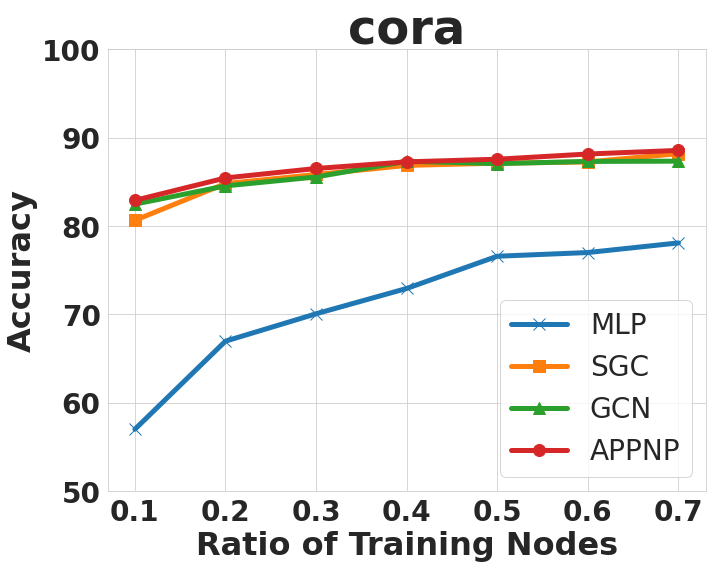

In [66]:
plt.plot(xticks, acc_dict['mlp'], linewidth=5, marker='x', markersize=12, label="MLP")
plt.plot(xticks, acc_dict['sgc'], linewidth=5, marker='s', markersize=12, label="SGC")
plt.plot(xticks, acc_dict['gcn'], linewidth=5, marker='^', markersize=12, label="GCN")
plt.plot(xticks, acc_dict['appnp'], linewidth=5, marker='o', markersize=12, label="APPNP")
plt.ylabel("Accuracy", fontsize=32, fontweight='bold')
plt.xlabel("Ratio of Training Nodes", fontsize=32, fontweight='bold')
plt.ylim(50, 100)
plt.yticks(fontsize=28, fontweight='bold')
plt.xticks(fontsize=28, fontweight='bold')
plt.title("cora", fontsize=48, fontweight='bold')
plt.legend(fontsize=28)
plt.tight_layout()
plt.show()

In [46]:
import numpy as np
import os
import random
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from cogdl import experiment
from cogdl.datasets.planetoid_data import CoraDataset
from custom_models.mlp import MLP
from custom_models.gcn import GCN
from custom_models.sgc import SGC
from custom_models.appnp import APPNP

dataset = CoraDataset()
graph = dataset.data

mlp = MLP(
    in_feats = dataset.num_features,
    out_feats = dataset.num_classes,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.5,
    activation = "relu",
)

gcn = GCN(
    in_feats = dataset.num_features,
    out_feats = dataset.num_classes,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.5,
    activation = "relu",
    residual = False,
    remove_self_loop = False,
    norm = None,
)

sgc = SGC(
    in_feats = dataset.num_features,
    out_feats = dataset.num_classes,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.5,
    activation = "relu",
    norm = None,
    order = 2,
    remove_self_loop = False,
    bias = True,
)

appnp = APPNP(nfeat=dataset.num_features, 
              nhid=64,
              nclass=dataset.num_classes,
              num_layers=2,
              dropout=0.5,
              alpha=0.1, 
              niter=2)

#   Model Test
#
#   | Variant       | test_acc      | val_acc       |
#   |---------------|---------------|---------------|
#   | (Cora, 'MLP') | 0.5500±0.0092 | 0.5920±0.0116 |
#   | (Cora, 'GCN') | 0.8086±0.0071 | 0.7932±0.0020 |
#   | (Cora, 'SGC') | 0.8040±0.0066 | 0.7968±0.0026 |

# experiment(model=[mlp, gcn, sgc], dataset=dataset, seed=list(range(10)), epoch=500, devices=[0])

# Train: 0%, 10%, 20% -> 70%, Valid: 20%, Test: total - train -valid 

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model_class = {
    'mlp': mlp,
#     'gcn': gcn,
#     'sgc': sgc,
#     'appnp': appnp,
}

results = []
n_post = 10

for i in range(1, 8):
    train_start = int(dataset.num_nodes * 0 / 10.0)
    train_end = int(dataset.num_nodes * i / 10.0)
    
    val_start = int(dataset.num_nodes * i / 10.0)
    val_end = int(dataset.num_nodes * (i+2) / 10.0)
    
    test_start = int(dataset.num_nodes * (i+2) / 10.0)
    test_end = int(dataset.num_nodes)
    
    perm = torch.randperm(dataset.num_nodes)

    graph.train_mask[:] = False
    graph.train_mask[perm[train_start:train_end]] = True

    graph.val_mask[:] = False
    graph.val_mask[perm[val_start:val_end]] = True

    graph.test_mask[:] = False
    graph.test_mask[perm[test_start:test_end]] = True
    
    # print ((graph.train_mask | graph.val_mask | graph.test_mask).sum().item(), graph.train_mask.sum().item() + graph.val_mask.sum().item() + graph.test_mask.sum().item())
    for model_name, model in model_class.items():
        acc = []
        for i in range(10):
            ret = experiment(model=model, dataset=dataset, seed=[i], epoch=500, devices=[0])

            model_wrapper = NodeClfModelWrapper(model, None)
            model_wrapper.load_state_dict(torch.load("./checkpoints/model.pt"))
            model = model_wrapper.model
            model.eval()
            x_post = copy.deepcopy(dataset.data.x)
            graph = copy.deepcopy(dataset.data)
            graph.add_remaining_self_loops()
            graph.sym_norm()
            val_accs, test_accs = [], []
            for n_post_prop in post_props:
                pred = model.forward(x_post)
                train_acc, val_acc, test_acc = utils.eval_acc(pred, dataset, verbose=False)
                val_accs.append(val_acc)
                test_accs.append(test_acc)
                x_post = spmm(graph, x_post)
            test_acc = test_accs[np.argmax(np.array(val_accs))]
            acc.append(test_acc)
        test_acc = np.mean(acc)
        items = {
            'train_percent': i,
            'model_name': model_name,
            'test_acc': round(test_acc * 100, 2)
        }
        
        results.append(items)

for result in results:
    print (result)


Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------------------------------------------|
    *** Running (`Cora`, `MLP`, `node_classification_dw`, `node_classification_mw`)
|----------------------------------------------------------------------------------------|
Model Parameters: 92231


Epoch: 158, train_loss:  0.0219, val_acc:  0.5701:  32%|███▏      | 158/500 [00:00<00:00, 342.41it/s]


Saving 59-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.540084388185654, 'val_acc': 0.577490774907749}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5401±0.0000 | 0.5775±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------

Epoch: 259, train_loss:  0.0043, val_acc:  0.5867:  52%|█████▏    | 259/500 [00:00<00:00, 343.19it/s]


Saving 160-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.560126582278481, 'val_acc': 0.5996309963099631}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5601±0.0000 | 0.5996±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 221, train_loss:  0.0011, val_acc:  0.5996:  44%|████▍     | 221/500 [00:00<00:00, 358.94it/s]


Saving 122-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5828059071729957, 'val_acc': 0.6107011070110702}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5828±0.0000 | 0.6107±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 209, train_loss:  0.0029, val_acc:  0.5996:  42%|████▏     | 209/500 [00:00<00:00, 362.75it/s]


Saving 110-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5828059071729957, 'val_acc': 0.6107011070110702}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5828±0.0000 | 0.6107±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 189, train_loss:  0.0016, val_acc:  0.6125:  38%|███▊      | 189/500 [00:00<00:00, 367.85it/s]


Saving 90-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5822784810126582, 'val_acc': 0.6143911439114391}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5823±0.0000 | 0.6144±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 100, train_loss:  0.0001, val_acc:  0.6052:  20%|██        | 100/500 [00:00<00:01, 366.42it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5854430379746836, 'val_acc': 0.6125461254612546}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5854±0.0000 | 0.6125±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 185, train_loss:  0.0001, val_acc:  0.6089:  37%|███▋      | 185/500 [00:00<00:00, 339.33it/s]


Saving 86-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5886075949367089, 'val_acc': 0.6107011070110702}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5886±0.0000 | 0.6107±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 112, train_loss:  0.0009, val_acc:  0.5996:  22%|██▏       | 112/500 [00:00<00:01, 340.74it/s]


Saving 13-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5970464135021097, 'val_acc': 0.6107011070110702}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5970±0.0000 | 0.6107±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 135, train_loss:  0.0063, val_acc:  0.6070:  27%|██▋       | 135/500 [00:00<00:01, 361.08it/s]


Saving 36-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5838607594936709, 'val_acc': 0.6088560885608856}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5839±0.0000 | 0.6089±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 135, train_loss:  0.0001, val_acc:  0.6107:  27%|██▋       | 135/500 [00:00<00:01, 357.21it/s]


Saving 36-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5991561181434599, 'val_acc': 0.6236162361623616}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5992±0.0000 | 0.6236±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 235, train_loss:  0.0035, val_acc:  0.5996:  47%|████▋     | 235/500 [00:00<00:00, 340.34it/s]


Saving 136-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6002109704641351, 'val_acc': 0.6180811808118081}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6002±0.0000 | 0.6181±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 311, train_loss:  0.0003, val_acc:  0.6218:  62%|██████▏   | 311/500 [00:00<00:00, 370.12it/s]


Saving 212-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6081223628691983, 'val_acc': 0.6236162361623616}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6081±0.0000 | 0.6236±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 136, train_loss:  0.0000, val_acc:  0.6125:  27%|██▋       | 136/500 [00:00<00:00, 373.36it/s]


Saving 37-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6007383966244726, 'val_acc': 0.6217712177121771}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6007±0.0000 | 0.6218±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 127, train_loss:  0.0003, val_acc:  0.6107:  25%|██▌       | 127/500 [00:00<00:00, 390.27it/s]


Saving 28-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6039029535864979, 'val_acc': 0.6236162361623616}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6039±0.0000 | 0.6236±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 290, train_loss:  0.0093, val_acc:  0.6218:  58%|█████▊    | 290/500 [00:00<00:00, 385.55it/s]


Saving 191-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5949367088607594, 'val_acc': 0.6273062730627307}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5949±0.0000 | 0.6273±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6255:  20%|██        | 100/500 [00:00<00:01, 365.74it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5965189873417721, 'val_acc': 0.6273062730627307}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5965±0.0000 | 0.6273±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 103, train_loss:  0.0000, val_acc:  0.6199:  21%|██        | 103/500 [00:00<00:01, 360.03it/s]


Saving 4-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.5959915611814346, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.5960±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 109, train_loss:  0.0008, val_acc:  0.6181:  22%|██▏       | 109/500 [00:00<00:01, 324.50it/s]


Saving 10-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6017932489451476, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6018±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 104, train_loss:  0.0009, val_acc:  0.6199:  21%|██        | 104/500 [00:00<00:01, 332.06it/s]


Saving 5-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6002109704641351, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6002±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 205, train_loss:  0.0002, val_acc:  0.6181:  41%|████      | 205/500 [00:00<00:00, 335.80it/s]


Saving 106-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6065400843881856, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6065±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 182, train_loss:  0.0000, val_acc:  0.6144:  36%|███▋      | 182/500 [00:00<00:00, 345.86it/s]


Saving 83-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6107594936708861, 'val_acc': 0.6273062730627307}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6108±0.0000 | 0.6273±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 102, train_loss:  0.0003, val_acc:  0.6125:  20%|██        | 102/500 [00:00<00:01, 383.37it/s]


Saving 3-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.614451476793249, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6145±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------

Epoch: 102, train_loss:  0.0001, val_acc:  0.6052:  20%|██        | 102/500 [00:00<00:01, 383.15it/s]


Saving 3-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6102320675105485, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6102±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 104, train_loss:  0.0031, val_acc:  0.6107:  21%|██        | 104/500 [00:00<00:01, 375.40it/s]


Saving 5-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.609704641350211, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6097±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6273:  20%|██        | 100/500 [00:00<00:01, 360.95it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6107594936708861, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6108±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 140, train_loss:  0.0050, val_acc:  0.6125:  28%|██▊       | 140/500 [00:00<00:01, 346.49it/s]


Saving 41-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6091772151898734, 'val_acc': 0.6273062730627307}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6092±0.0000 | 0.6273±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 108, train_loss:  0.0034, val_acc:  0.6236:  22%|██▏       | 108/500 [00:00<00:01, 365.04it/s]


Saving 9-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6112869198312236, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6113±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 114, train_loss:  0.0001, val_acc:  0.6181:  23%|██▎       | 114/500 [00:00<00:01, 376.01it/s]


Saving 15-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6170886075949367, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6171±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 153, train_loss:  0.0013, val_acc:  0.6218:  31%|███       | 153/500 [00:00<00:01, 332.16it/s]


Saving 54-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6065400843881856, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6065±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 100, train_loss:  0.0001, val_acc:  0.6144:  20%|██        | 100/500 [00:00<00:01, 366.89it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6070675105485233, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6071±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 175, train_loss:  0.0000, val_acc:  0.6236:  35%|███▌      | 175/500 [00:00<00:00, 332.36it/s]


Saving 76-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6160337552742616, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6160±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 152, train_loss:  0.0001, val_acc:  0.6144:  30%|███       | 152/500 [00:00<00:00, 348.23it/s]


Saving 53-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6118143459915611, 'val_acc': 0.6254612546125461}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6118±0.0000 | 0.6255±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 141, train_loss:  0.0003, val_acc:  0.6144:  28%|██▊       | 141/500 [00:00<00:01, 358.91it/s]


Saving 42-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6091772151898734, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6092±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 101, train_loss:  0.0000, val_acc:  0.6125:  20%|██        | 101/500 [00:00<00:01, 364.83it/s]


Saving 2-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6075949367088608, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6076±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 176, train_loss:  0.0001, val_acc:  0.6199:  35%|███▌      | 176/500 [00:00<00:00, 360.81it/s]


Saving 77-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6213080168776371, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6213±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 101, train_loss:  0.0001, val_acc:  0.6236:  20%|██        | 101/500 [00:00<00:01, 328.48it/s]


Saving 2-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6181434599156118, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6181±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6052:  20%|██        | 100/500 [00:00<00:01, 347.39it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6176160337552743, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6176±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 103, train_loss:  0.0000, val_acc:  0.6181:  21%|██        | 103/500 [00:00<00:01, 356.77it/s]


Saving 4-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6213080168776371, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6213±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6218:  20%|██        | 100/500 [00:00<00:01, 370.02it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.619198312236287, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6192±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------

Epoch: 177, train_loss:  0.0004, val_acc:  0.6236:  35%|███▌      | 177/500 [00:00<00:00, 356.83it/s]


Saving 78-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6186708860759493, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6187±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 147, train_loss:  0.0034, val_acc:  0.6199:  29%|██▉       | 147/500 [00:00<00:00, 372.89it/s]


Saving 48-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.614451476793249, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6145±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 143, train_loss:  0.0000, val_acc:  0.6144:  29%|██▊       | 143/500 [00:00<00:01, 328.00it/s]


Saving 44-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6133966244725738, 'val_acc': 0.6254612546125461}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6134±0.0000 | 0.6255±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 459, train_loss:  0.0039, val_acc:  0.6236:  92%|█████████▏| 459/500 [00:01<00:00, 367.82it/s]


Saving 360-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6133966244725738, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6134±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 162, train_loss:  0.0002, val_acc:  0.6255:  32%|███▏      | 162/500 [00:00<00:00, 366.40it/s]


Saving 63-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.615506329113924, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6155±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6199:  20%|██        | 100/500 [00:00<00:01, 381.71it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6160337552742616, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6160±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 167, train_loss:  0.0001, val_acc:  0.6125:  33%|███▎      | 167/500 [00:00<00:00, 351.93it/s]


Saving 68-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6133966244725738, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6134±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 254, train_loss:  0.0000, val_acc:  0.6236:  51%|█████     | 254/500 [00:00<00:00, 361.33it/s]


Saving 155-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6213080168776371, 'val_acc': 0.6309963099630996}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6213±0.0000 | 0.6310±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 122, train_loss:  0.0009, val_acc:  0.6199:  24%|██▍       | 122/500 [00:00<00:01, 338.48it/s]


Saving 23-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6234177215189873, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6234±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 103, train_loss:  0.0000, val_acc:  0.6310:  21%|██        | 103/500 [00:00<00:01, 353.40it/s]


Saving 4-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6218354430379747, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6218±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 162, train_loss:  0.0004, val_acc:  0.6255:  32%|███▏      | 162/500 [00:00<00:00, 355.23it/s]


Saving 63-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6265822784810127, 'val_acc': 0.6365313653136532}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6266±0.0000 | 0.6365±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 102, train_loss:  0.0000, val_acc:  0.6236:  20%|██        | 102/500 [00:00<00:01, 353.08it/s]


Saving 3-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6234177215189873, 'val_acc': 0.6365313653136532}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6234±0.0000 | 0.6365±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 119, train_loss:  0.0000, val_acc:  0.6236:  24%|██▍       | 119/500 [00:00<00:01, 355.50it/s]


Saving 20-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.625, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6250±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------------------

Epoch: 193, train_loss:  0.0000, val_acc:  0.6292:  39%|███▊      | 193/500 [00:00<00:00, 336.93it/s]


Saving 94-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6213080168776371, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6213±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 131, train_loss:  0.0000, val_acc:  0.6218:  26%|██▌       | 131/500 [00:00<00:01, 349.65it/s]


Saving 32-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.619198312236287, 'val_acc': 0.6365313653136532}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6192±0.0000 | 0.6365±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 170, train_loss:  0.0001, val_acc:  0.6181:  34%|███▍      | 170/500 [00:00<00:00, 363.32it/s]


Saving 71-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6223628691983122, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6224±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 193, train_loss:  0.0000, val_acc:  0.6162:  39%|███▊      | 193/500 [00:00<00:00, 370.70it/s]


Saving 94-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6213080168776371, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6213±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 150, train_loss:  0.0000, val_acc:  0.6236:  30%|███       | 150/500 [00:00<00:00, 363.90it/s]


Saving 51-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6271097046413502, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6271±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 108, train_loss:  0.0002, val_acc:  0.6255:  22%|██▏       | 108/500 [00:00<00:01, 367.26it/s]


Saving 9-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6292194092827004, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6292±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 311, train_loss:  0.0000, val_acc:  0.6236:  62%|██████▏   | 311/500 [00:00<00:00, 364.99it/s]


Saving 212-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6128691983122363, 'val_acc': 0.6365313653136532}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6129±0.0000 | 0.6365±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|-------------------------------------------------

Epoch: 192, train_loss:  0.0000, val_acc:  0.6218:  38%|███▊      | 192/500 [00:00<00:00, 347.85it/s]


Saving 93-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6265822784810127, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6266±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[0], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 112, train_loss:  0.0000, val_acc:  0.6255:  22%|██▏       | 112/500 [00:00<00:01, 351.03it/s]


Saving 13-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6244725738396625, 'val_acc': 0.6273062730627307}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6245±0.0000 | 0.6273±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[1], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6089:  20%|██        | 100/500 [00:00<00:01, 327.08it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.625, 'val_acc': 0.6291512915129152}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6250±0.0000 | 0.6292±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[2], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|----------------------------------------------------------------

Epoch: 180, train_loss:  0.0000, val_acc:  0.6273:  36%|███▌      | 180/500 [00:00<00:00, 357.66it/s]


Saving 81-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6207805907172996, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6208±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[3], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 130, train_loss:  0.0001, val_acc:  0.6162:  26%|██▌       | 130/500 [00:00<00:01, 358.00it/s]


Saving 31-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6244725738396625, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6245±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[4], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 187, train_loss:  0.0000, val_acc:  0.6255:  37%|███▋      | 187/500 [00:00<00:00, 355.89it/s]


Saving 88-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6276371308016878, 'val_acc': 0.6365313653136532}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6276±0.0000 | 0.6365±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[5], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 101, train_loss:  0.0000, val_acc:  0.6292:  20%|██        | 101/500 [00:00<00:01, 363.05it/s]


Saving 2-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6244725738396625, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6245±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[6], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6144:  20%|██        | 100/500 [00:00<00:01, 365.11it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6234177215189873, 'val_acc': 0.6328413284132841}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6234±0.0000 | 0.6328±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[7], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 166, train_loss:  0.0015, val_acc:  0.6218:  33%|███▎      | 166/500 [00:00<00:00, 367.79it/s]


Saving 67-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6281645569620253, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6282±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[8], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|--------------------------------------------------

Epoch: 100, train_loss:  0.0000, val_acc:  0.6218:  20%|██        | 100/500 [00:00<00:01, 387.12it/s]


Saving 1-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6281645569620253, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6282±0.0000 | 0.6347±0.0000 |
Namespace(actnn=False, checkpoint_path='./checkpoints/model.pt', cpu=False, cpu_inference=False, dataset=['Cora'], devices=[0], distributed=False, dw='node_classification_dw', epoch=500, epochs=500, eval_step=1, fp16=False, load_emb_path=None, local_rank=0, log_path='.', logger=None, lr=0.01, master_addr='localhost', master_port=13425, max_epoch=None, model=['MLP'], mw='node_classification_mw', n_trials=3, n_warmup_steps=0, no_test=False, nstage=1, patience=100, progress_bar='epoch', project='cogdl-exp', resume_training=False, rp_ratio=1, save_emb_path=None, seed=[9], split=[0], unsup=False, use_best_config=False, weight_decay=0)
 
|---------------------------------------------------

Epoch: 101, train_loss:  0.0000, val_acc:  0.6199:  20%|██        | 101/500 [00:00<00:01, 384.06it/s]


Saving 2-th model to ./checkpoints/model.pt ...
Loading model from ./checkpoints/model.pt ...
{'test_acc': 0.6286919831223629, 'val_acc': 0.6346863468634686}
| Variant       | test_acc      | val_acc       |
|---------------|---------------|---------------|
| (Cora, 'MLP') | 0.6287±0.0000 | 0.6347±0.0000 |
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 65.43}
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 68.9}
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 70.28}
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 71.51}
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 72.36}
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 73.12}
{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 72.78}


In [47]:
results

[{'train_percent': 9, 'model_name': 'mlp', 'test_acc': 65.43},
 {'train_percent': 9, 'model_name': 'mlp', 'test_acc': 68.9},
 {'train_percent': 9, 'model_name': 'mlp', 'test_acc': 70.28},
 {'train_percent': 9, 'model_name': 'mlp', 'test_acc': 71.51},
 {'train_percent': 9, 'model_name': 'mlp', 'test_acc': 72.36},
 {'train_percent': 9, 'model_name': 'mlp', 'test_acc': 73.12},
 {'train_percent': 9, 'model_name': 'mlp', 'test_acc': 72.78}]